# Импорты

In [1]:
from sklearn.metrics import f1_score
from tqdm import tqdm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier, CatBoostError
from sklearn.model_selection import train_test_split
import numpy as np

# Для более качественных графиков
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.dpi"] = 150

# Датасет

In [2]:
TARGET = "дефолт"
loan_data = pd.read_csv("data/loan_data.csv")
loan_data

ID  лимит_нарушен  пол  тип  цель  \
0     9e0a294e-c3cc-4aac-a489-41f479a55d6f            0.0    м  3.0   0.0   
1     e1509425-891f-4683-9e12-dbf1493d6196            0.0  NaN  NaN   0.0   
2     10b6a662-2ac1-45ca-8e5d-8f1296b31f4a            0.0    м  3.0   1.0   
3     3b895644-549d-43b5-8dfe-448cacb70476            0.0  NaN  3.0   1.0   
4     e0b641d0-4345-429c-9655-8df410af54cc            0.0  NaN  3.0   1.0   
...                                    ...            ...  ...  ...   ...   
7995  dcadfda8-ece0-47bb-9835-9b4b4dfcf384            0.0  NaN  3.0   1.0   
7996  2b39e995-c13e-40d3-823a-0b12d6baf0f2            NaN  NaN  NaN   1.0   
7997  b44aad77-b20c-4a3f-bee8-acf10b3e2b6e            0.0    м  3.0   3.0   
7998  98cf1188-06d2-4913-a117-3719b023a0ea            NaN  NaN  NaN   1.0   
7999  67e39166-323e-4a41-8520-89dcd5eb6f69            0.0    ж  1.0   0.0   

      кредитоспособность  другие_кредиты  бизнес          сумма  \
0                    1.0             NaN     0.0  174765.264968   
1                    1.0             0.0     0.0            NaN   
2                    1.0             0.0     0.0            NaN   
3                    1.0             0.0     0.0  474765.264968   
4                    NaN             0.0     0.0  384765.264968   
...                  ...             ...     ...            ...   
7995                 NaN             0.0     0.0            NaN   
7996                 1.0             0.0     1.0            NaN   
7997                 1.0             NaN     0.0  394765.264968   
7998                 1.0             0.0     0.0  594765.264968   
7999                 1.0             0.0     0.0  684765.264968   

                        сбор  ...  один_платеж  стоимость_имущества  работа  \
0                     normal  ...          0.0        244488.111841     осн   
1                       want  ...          0.0                  NaN     осн   
2                    regular  ...          NaN        364488.111841     осн   
3                     common  ...          0.0        894488.111841     осн   
4                  excessive  ...          0.0        504488.111841     осн   
...                      ...  ...          ...                  ...     ...   
7995              not slight  ...          0.0        744488.111841     осн   
7996                    mean  ...          0.0        184488.111841     осн   
7997     Whole lotta nothin'  ...          0.0                  NaN     осн   
7998  Total lack of presence  ...          0.0                  NaN     осн   
7999               minuscule  ...          0.0                  NaN     осн   

      тип_залога  тип_кредита кредитный_рейтинг возраст  прямой_залог  дефолт  \
0            дом          2.0        709.508335   55-64           1.0       0   
1            дом          1.0        722.508335   55-64           NaN       0   
2            дом          1.0        785.508335   55-64           1.0       0   
3            дом          NaN        594.508335   35-44           1.0       0   
4            дом          NaN        589.508335   55-64           NaN       0   
...          ...          ...               ...     ...           ...     ...   
7995         дом          2.0               NaN   35-44           NaN       0   
7996         дом          1.0        796.508335     >74           1.0       0   
7997         дом          4.0        584.508335   25-34           1.0       1   
7998         дом          NaN        873.508335   35-44           1.0       0   
7999         дом          2.0               NaN   35-44           1.0       0   

                                                   речь  
0     "Hey there! I’m a guy with a solid job and a m...  
1     "Hi there! We are a couple with a solid financ...  
2     "I'm a male client with a modest income. I wor...  
3     "Hello, we’re a working couple enjoying the st...  
4     "Greetings, we're Chris and Sam. Both employed...  
...                                     

In [3]:
loan_data = loan_data.drop(columns="ID")

### Бизнес: какова задача

Имеем список клиентов банка и разметку того, расплатились ли они за кредит. Банк всегда выдает кредит со ставкой 10% годовых. Бизнес-задача: суметь предсказывать дефолт клиента, чтобы отказывать таким клиентам/повышать ставку для них

### Датасет: какие есть признаки

### Модель: бейзлайн (константное значение)

In [4]:
def baseline(loan_data: pd.DataFrame) -> None:
    y = loan_data[TARGET]
    pred = y.mode()[0]
    acc = (y == pred).mean()
    print(f"Accuracy: {acc:.3f}")


baseline(loan_data)

Accuracy: 0.763


### Модель: без исследования

При таком решении я могу построить лог рег/бустинг и посчитать точность/f1 на всем датасете. Стоит ли обойтись здесь самыми простыми вариантами? Нужно ли им отдельно говорить о нормализации/заполнении пропущенных значений здесь?

In [5]:
def get_xy(loan_data: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    return loan_data.drop(columns=TARGET), loan_data[TARGET]


class ManualFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features):  # type: ignore[no-untyped-def]
        self.features = list(features)

    def fit(self, X, y=None):  # type: ignore[no-untyped-def]
        return self

    def transform(self, X):  # type: ignore[no-untyped-def]
        return X[self.features]


class ObjectToStringTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):  # type: ignore[no-untyped-def]
        return self

    def transform(self, X):  # type: ignore[no-untyped-def]
        X = X.copy()  # Avoid modifying the original DataFrame
        cat_cols = X.select_dtypes(object).columns
        X[cat_cols] = X[cat_cols].astype(str)
        return X


In [6]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression


def train_log_reg(loan_data: pd.DataFrame) -> None:
    X, y = get_xy(loan_data)
    num_cols = X.select_dtypes(exclude=object).columns

    pipe = Pipeline(
        [
            ("feat_select", ManualFeatureSelector(num_cols)),
            ("impute", SimpleImputer(strategy="constant", fill_value=0)),
            ("model", LogisticRegression(random_state=42)),
        ]
    )

    pipe.fit(X, y)
    pred = pipe.predict(X)
    acc = (pred == y).mean()
    print("Log reg")
    print(f"Accuracy: {acc:.3f}")
    f1 = f1_score(y_pred=pred, y_true=y)
    print(f"f1: {f1:.3f}")
    print()


def train_catboost(loan_data: pd.DataFrame) -> None:
    X, y = get_xy(loan_data)
    cat_cols = list(X.select_dtypes(object).columns)

    model = CatBoostClassifier(cat_features=cat_cols, random_state=42, allow_writing_files=False, verbose=False)
    pipe = Pipeline(
        [
            ("cat_to_str", ObjectToStringTransformer()),
            ("model", model),
        ]
    )

    pipe.fit(X, y)
    pred = pipe.predict(X)
    acc = (pred == y).mean()
    print("Catboost")
    print(f"Accuracy: {acc:.3f}")
    f1 = f1_score(y_pred=pred, y_true=y)
    print(f"f1: {f1:.3f}")


train_log_reg(loan_data)
train_catboost(loan_data)

/Users/user/Main/Repos/hse-ml-managers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Log reg
Accuracy: 0.812
f1: 0.441

Catboost
Accuracy: 0.962
f1: 0.917


### Датасет: какие есть признаки, какие у них значения

Тут можно быть более интерактивным? Каждую фичу можно потыкать по указанию

In [7]:
loan_data.iloc[:, :12]

лимит_нарушен  пол  тип  цель  кредитоспособность  другие_кредиты  \
0               0.0    м  3.0   0.0                 1.0             NaN   
1               0.0  NaN  NaN   0.0                 1.0             0.0   
2               0.0    м  3.0   1.0                 1.0             0.0   
3               0.0  NaN  3.0   1.0                 1.0             0.0   
4               0.0  NaN  3.0   1.0                 NaN             0.0   
...             ...  ...  ...   ...                 ...             ...   
7995            0.0  NaN  3.0   1.0                 NaN             0.0   
7996            NaN  NaN  NaN   1.0                 1.0             0.0   
7997            0.0    м  3.0   3.0                 1.0             NaN   
7998            NaN  NaN  NaN   1.0                 1.0             0.0   
7999            0.0    ж  1.0   0.0                 1.0             0.0   

      бизнес          сумма                    сбор        срок  амортизация  \
0        0.0  174765.264968                  normal  245.885949          0.0   
1        0.0            NaN                    want  365.885949          0.0   
2        0.0            NaN                 regular  365.885949          0.0   
3        0.0  474765.264968                  common  365.885949          0.0   
4        0.0  384765.264968               excessive  365.885949          0.0   
...      ...            ...                     ...         ...          ...   
7995     0.0            NaN              not slight  125.885949          0.0   
7996     1.0            NaN                    mean  185.885949          0.0   
7997     0.0  394765.264968     Whole lotta nothin'  365.885949          0.0   
7998     0.0  594765.264968  Total lack of presence  365.885949          0.0   
7999     0.0  684765.264968               minuscule  365.885949          0.0   

      только_процент  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  
...              ...  
7995             0.0  
7996             1.0  
7997             0.0  
7998             0.0  
7999             0.0  

[8000 rows x 12 columns]

In [8]:
loan_data.iloc[:, 12:]

один_платеж  стоимость_имущества работа тип_залога  тип_кредита  \
0             0.0        244488.111841    осн        дом          2.0   
1             0.0                  NaN    осн        дом          1.0   
2             NaN        364488.111841    осн        дом          1.0   
3             0.0        894488.111841    осн        дом          NaN   
4             0.0        504488.111841    осн        дом          NaN   
...           ...                  ...    ...        ...          ...   
7995          0.0        744488.111841    осн        дом          2.0   
7996          0.0        184488.111841    осн        дом          1.0   
7997          0.0                  NaN    осн        дом          4.0   
7998          0.0                  NaN    осн        дом          NaN   
7999          0.0                  NaN    осн        дом          2.0   

      кредитный_рейтинг возраст  прямой_залог  дефолт  \
0            709.508335   55-64           1.0       0   
1            722.508335   55-64           NaN       0   
2            785.508335   55-64           1.0       0   
3            594.508335   35-44           1.0       0   
4            589.508335   55-64           NaN       0   
...                 ...     ...           ...     ...   
7995                NaN   35-44           NaN       0   
7996         796.508335     >74           1.0       0   
7997         584.508335   25-34           1.0       1   
7998         873.508335   35-44           1.0       0   
7999                NaN   35-44           1.0       0   

                                                   речь  
0     "Hey there! I’m a guy with a solid job and a m...  
1     "Hi there! We are a couple with a solid financ...  
2     "I'm a male client with a modest income. I wor...  
3     "Hello, we’re a working couple enjoying the st...  
4     "Greetings, we're Chris and Sam. Both employed...  
...                                                 ...  
7995  "Hello! I’m here to introduce myself. I have a...  
7996  "Hello! I’m excited to be here. My income is m...  
7997  "I'm just an ordinary guy trying to make ends ...  
7998  "Hello! We’re a couple looking to manage our f...  
7999  "I'm a successful businesswoman with a dedicat...  

[8000 rows x 10 columns]

In [9]:
loan_data.describe()

лимит_нарушен          тип         цель  кредитоспособность  \
count    6462.000000  6466.000000  6442.000000          6406.00000   
mean        0.065305     2.664089     1.118131             0.96113   
std         0.247082     0.653671     1.138390             0.19330   
min         0.000000     1.000000     0.000000             0.00000   
25%         0.000000     3.000000     0.000000             1.00000   
50%         0.000000     3.000000     1.000000             1.00000   
75%         0.000000     3.000000     2.000000             1.00000   
max         1.000000     3.000000     3.000000             1.00000   

       другие_кредиты       бизнес         сумма         срок  амортизация  \
count     6425.000000  6369.000000  6.414000e+03  6376.000000  6338.000000   
mean         0.004669     0.134715  3.484416e+05   340.620736     0.101925   
std          0.068178     0.341446  1.842944e+05    59.079085     0.302573   
min          0.000000     0.000000  4.476526e+04   101.885949     0.000000   
25%          0.000000     0.000000  2.147653e+05   365.885949     0.000000   
50%          0.000000     0.000000  3.147653e+05   365.885949     0.000000   
75%          0.000000     0.000000  4.522653e+05   365.885949     0.000000   
max          1.000000     1.000000  3.024765e+06   365.885949     1.000000   

       только_процент  один_платеж  стоимость_имущества  тип_кредита  \
count     6435.000000  6396.000000         5.790000e+03  6340.000000   
mean         0.050971     0.019856         5.386556e+05     2.148580   
std          0.219956     0.139517         3.607842e+05     0.986423   
min          0.000000     0.000000         7.448811e+04     1.000000   
25%          0.000000     0.000000         3.144881e+05     1.000000   
50%          0.000000     0.000000         4.544881e+05     2.000000   
75%          0.000000     0.000000         6.644881e+05     3.000000   
max          1.000000     1.000000         4.914488e+06     4.000000   

       кредитный_рейтинг  прямой_залог       дефолт  
count        6386.000000   6420.000000  8000.000000  
mean          710.309933      0.999844     0.236750  
std           115.213366      0.012481     0.425114  
min           511.508335      0.000000     0.000000  
25%           611.508335      1.000000     0.000000  
50%           708.508335      1.000000     0.000000  
75%           810.508335      1.000000     0.000000  
max           911.508335      1.000000     1.000000

In [10]:
def get_num_cols(loan_data: pd.DataFrame) -> list[str]:
    cols = loan_data.select_dtypes(exclude=object).columns
    return [c for c in cols if loan_data[c].nunique() >= 20]


def get_cat_cols(loan_data: pd.DataFrame, for_plot: bool = False) -> list[str]:
    num_cols = get_num_cols(loan_data)
    cat_cols = list(set(loan_data.columns) - set(num_cols))
    if for_plot:
        cat_cols = [c for c in cat_cols if loan_data[c].nunique() < 20]
    return cat_cols

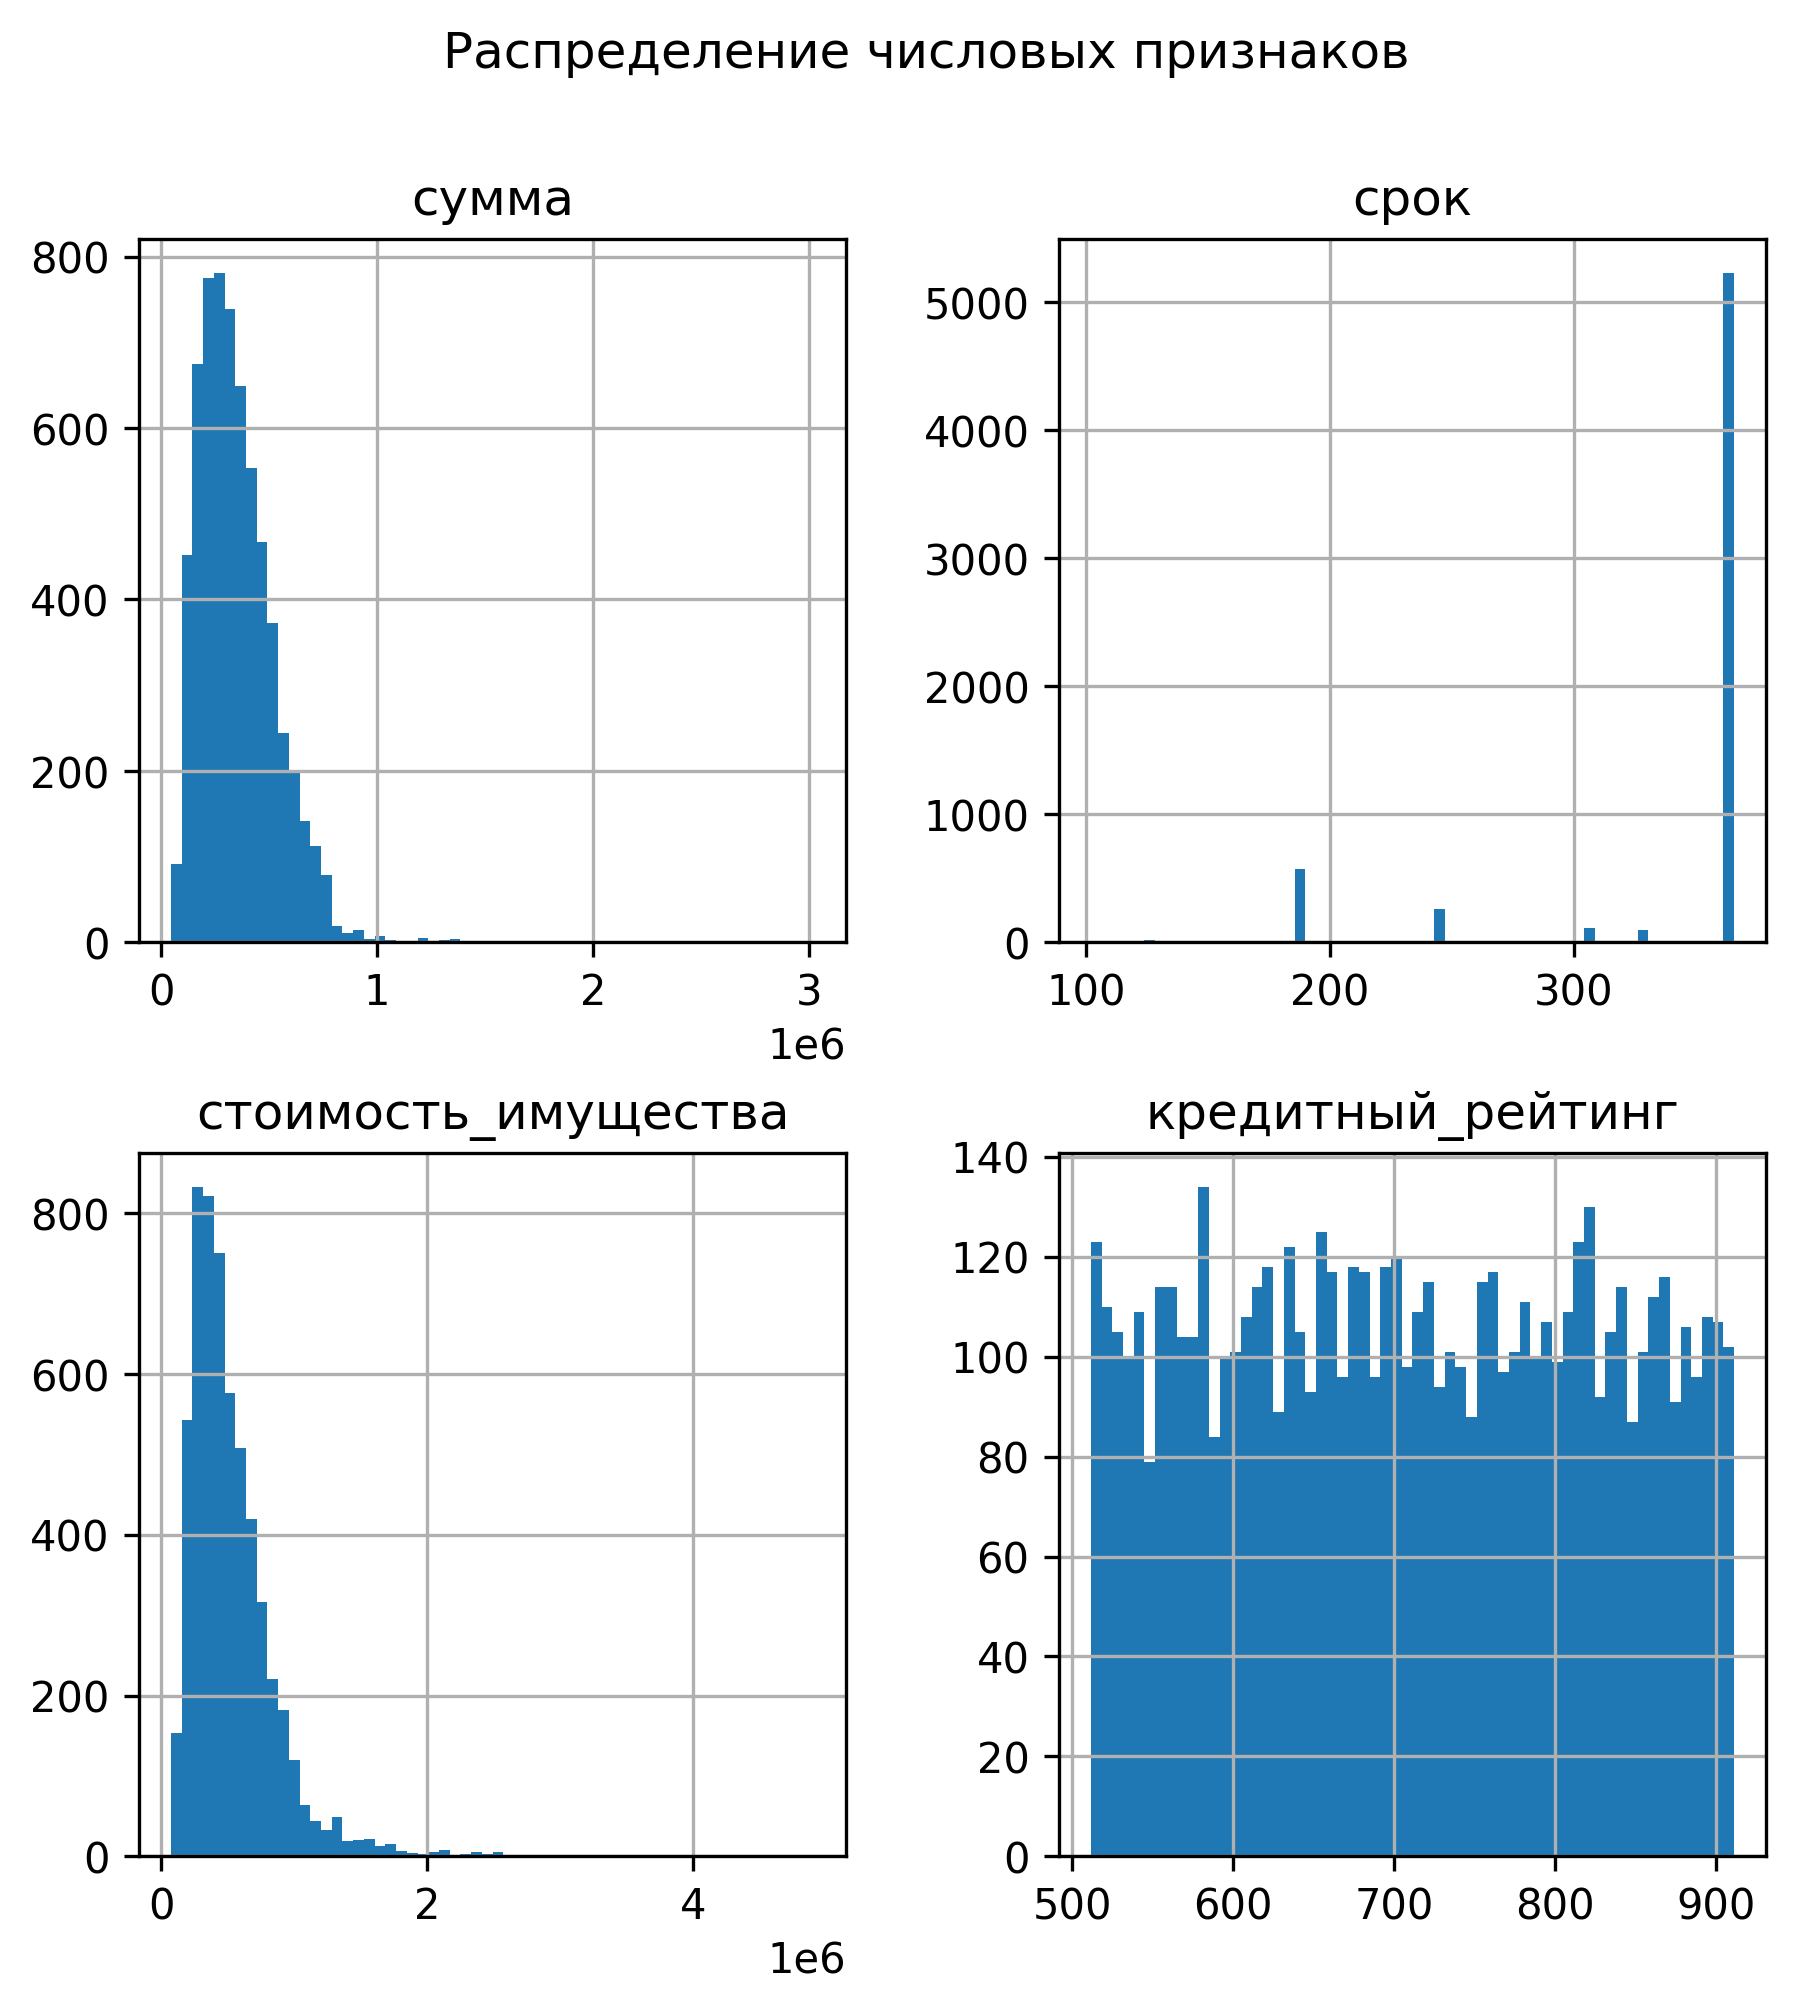

In [11]:
def plot_hist(loan_data: pd.DataFrame) -> None:
    num_cols = get_num_cols(loan_data)
    loan_data[num_cols].hist(bins=60, figsize=(7, 7))
    plt.suptitle("Распределение числовых признаков")
    plt.show()


plot_hist(loan_data)

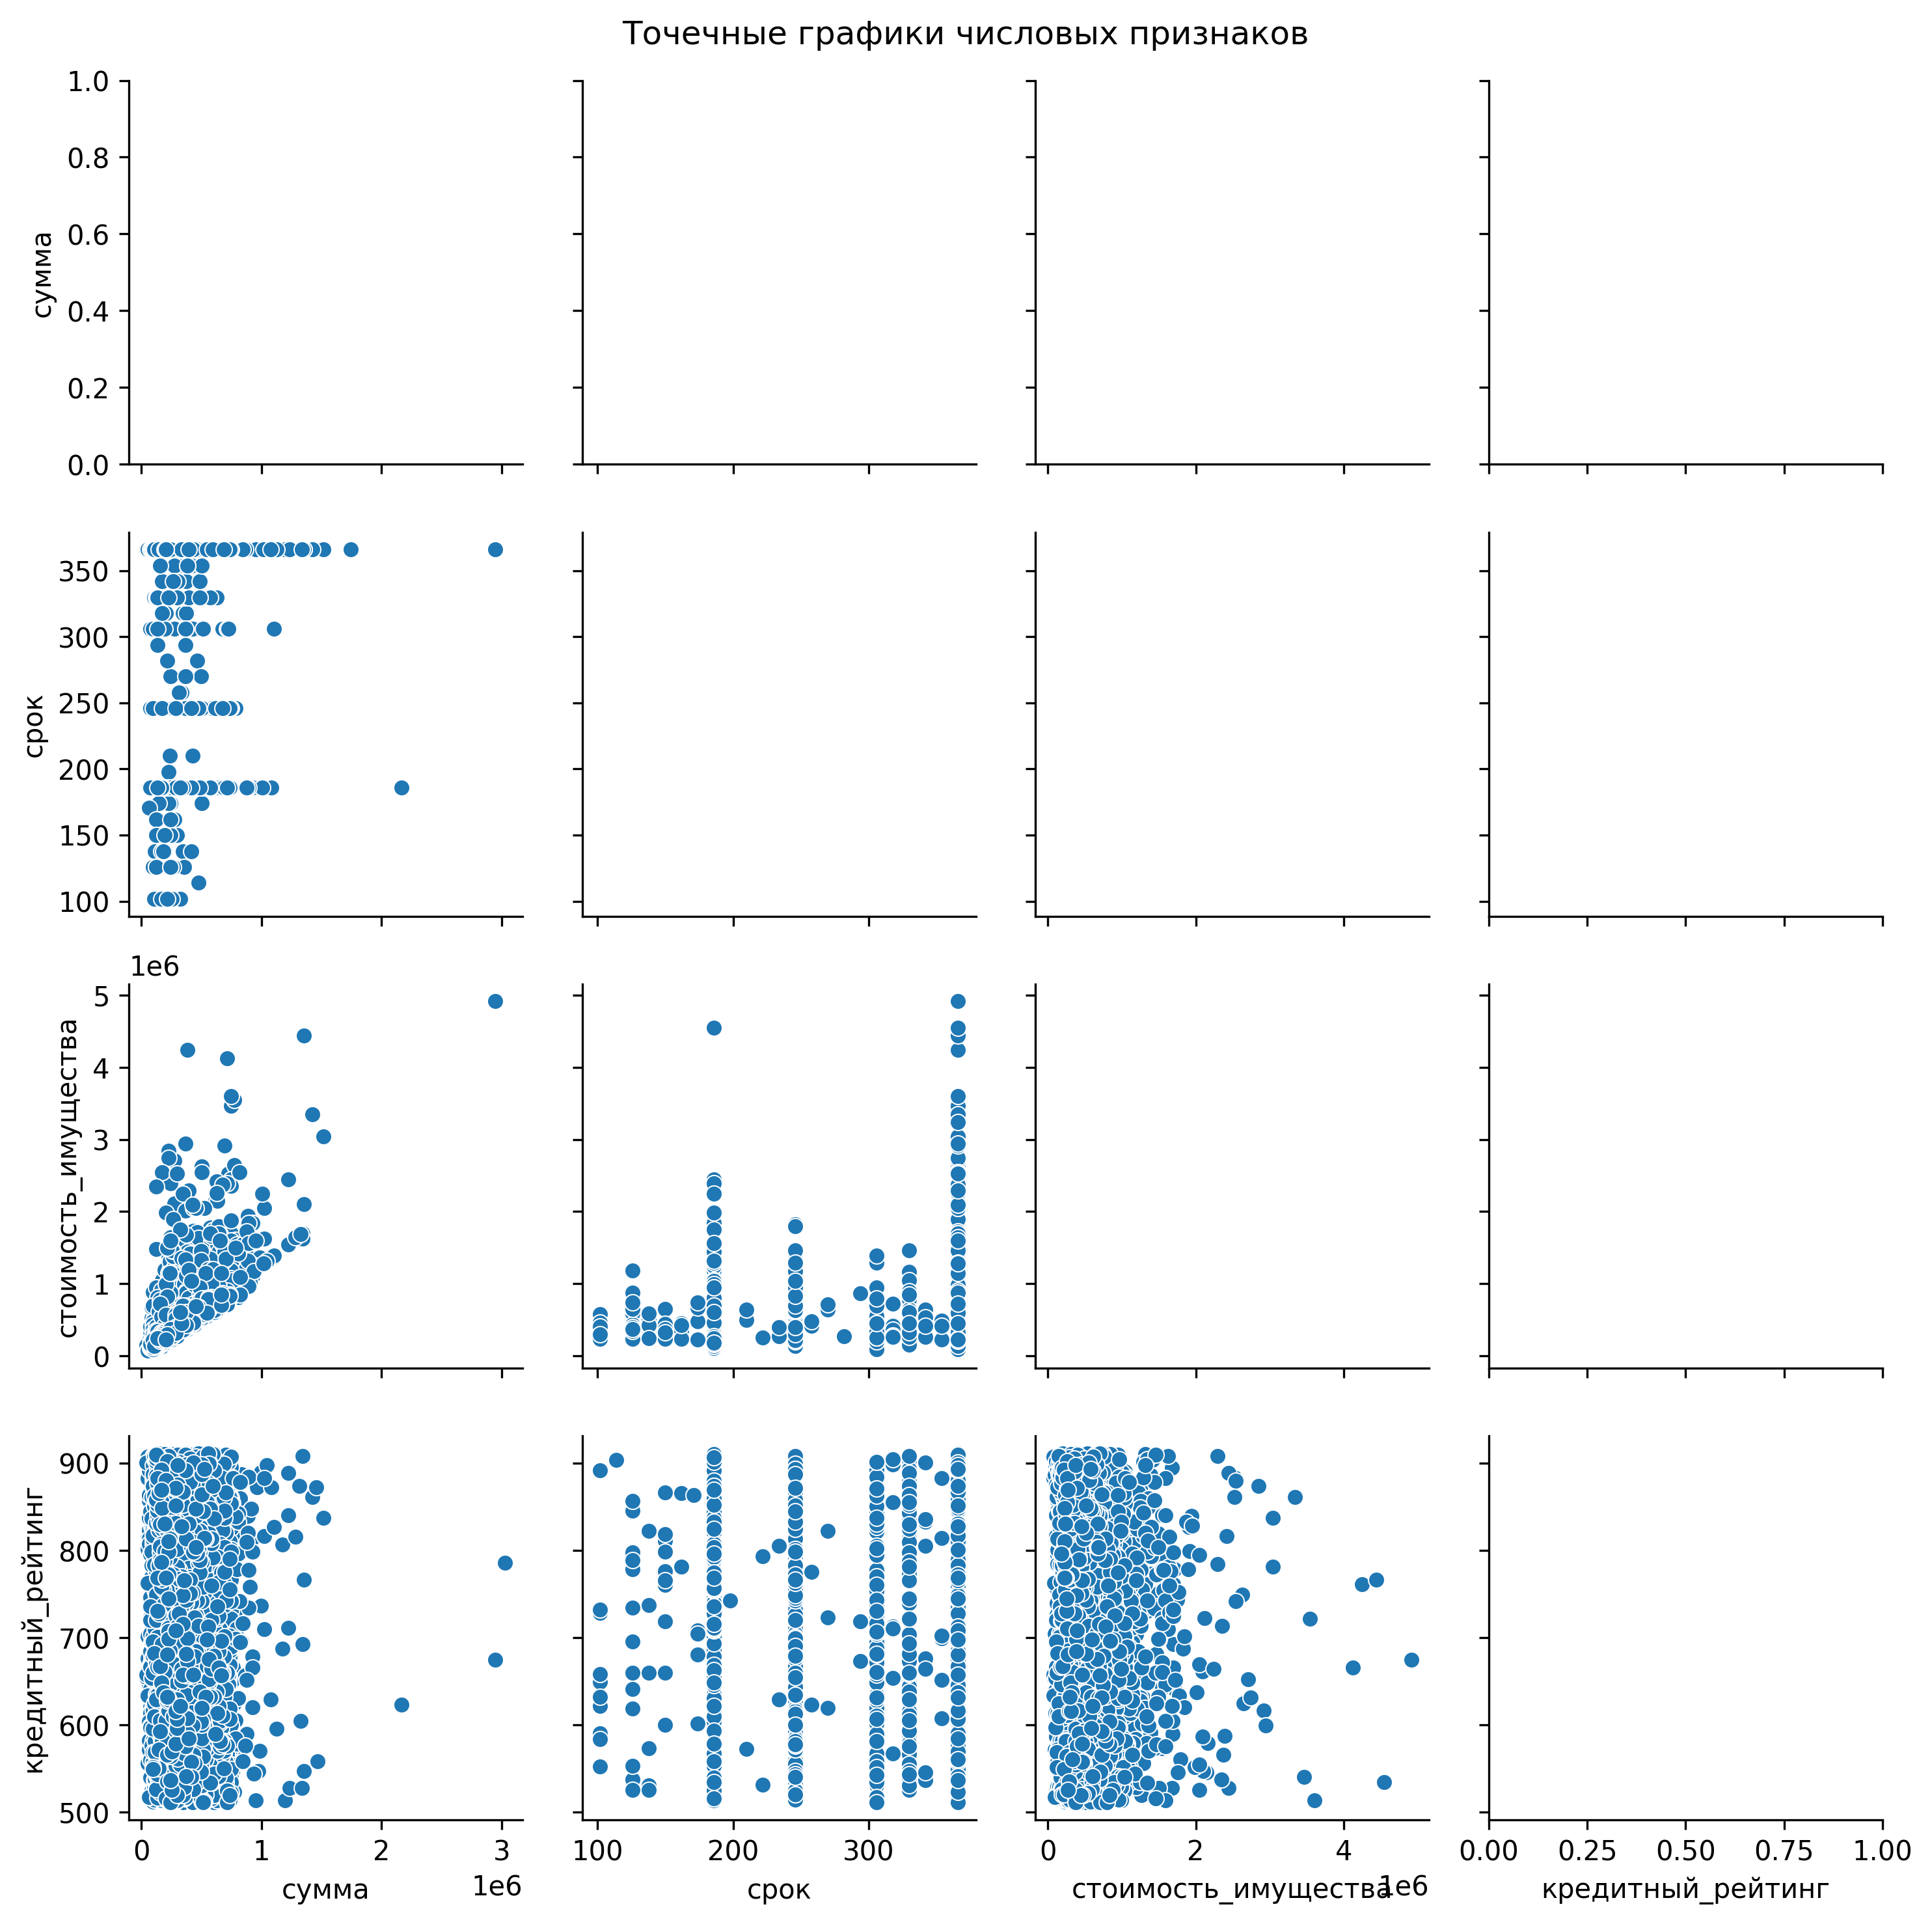

In [12]:
def plot_scatter(loan_data: pd.DataFrame) -> None:
    num_cols = get_num_cols(loan_data)
    g = sns.PairGrid(loan_data, x_vars=num_cols, y_vars=num_cols)
    g.map_lower(sns.scatterplot)
    plt.suptitle("Точечные графики числовых признаков")
    plt.tight_layout()
    plt.show()


plot_scatter(loan_data)

In [13]:
def print_value_counts(loan_data: pd.DataFrame) -> None:
    cat_cols = get_cat_cols(loan_data)
    for col in cat_cols:
        print(loan_data[col].value_counts())
        print()


print_value_counts(loan_data)

другие_кредиты
0.0    6395
1.0      30
Name: count, dtype: int64

лимит_нарушен
0.0    6040
1.0     422
Name: count, dtype: int64

тип_залога
дом      7998
земля       2
Name: count, dtype: int64

только_процент
0.0    6107
1.0     328
Name: count, dtype: int64

амортизация
0.0    5692
1.0     646
Name: count, dtype: int64

работа
осн       7455
инвест     375
втор       170
Name: count, dtype: int64

возраст
45-54    1878
35-44    1777
55-64    1696
65-74    1137
25-34    1046
>74       376
<25        82
Name: count, dtype: int64

тип
3.0    4954
2.0     852
1.0     660
Name: count, dtype: int64

речь
"I'm a dedicated professional with a stable job, looking to manage my finances better. I believe in planning for the future and am eager to explore options that can help me achieve my goals. I appreciate your assistance in this journey."                                                                                      7
"Hello! I'm a dedicated professional with a stable job, and I'm h

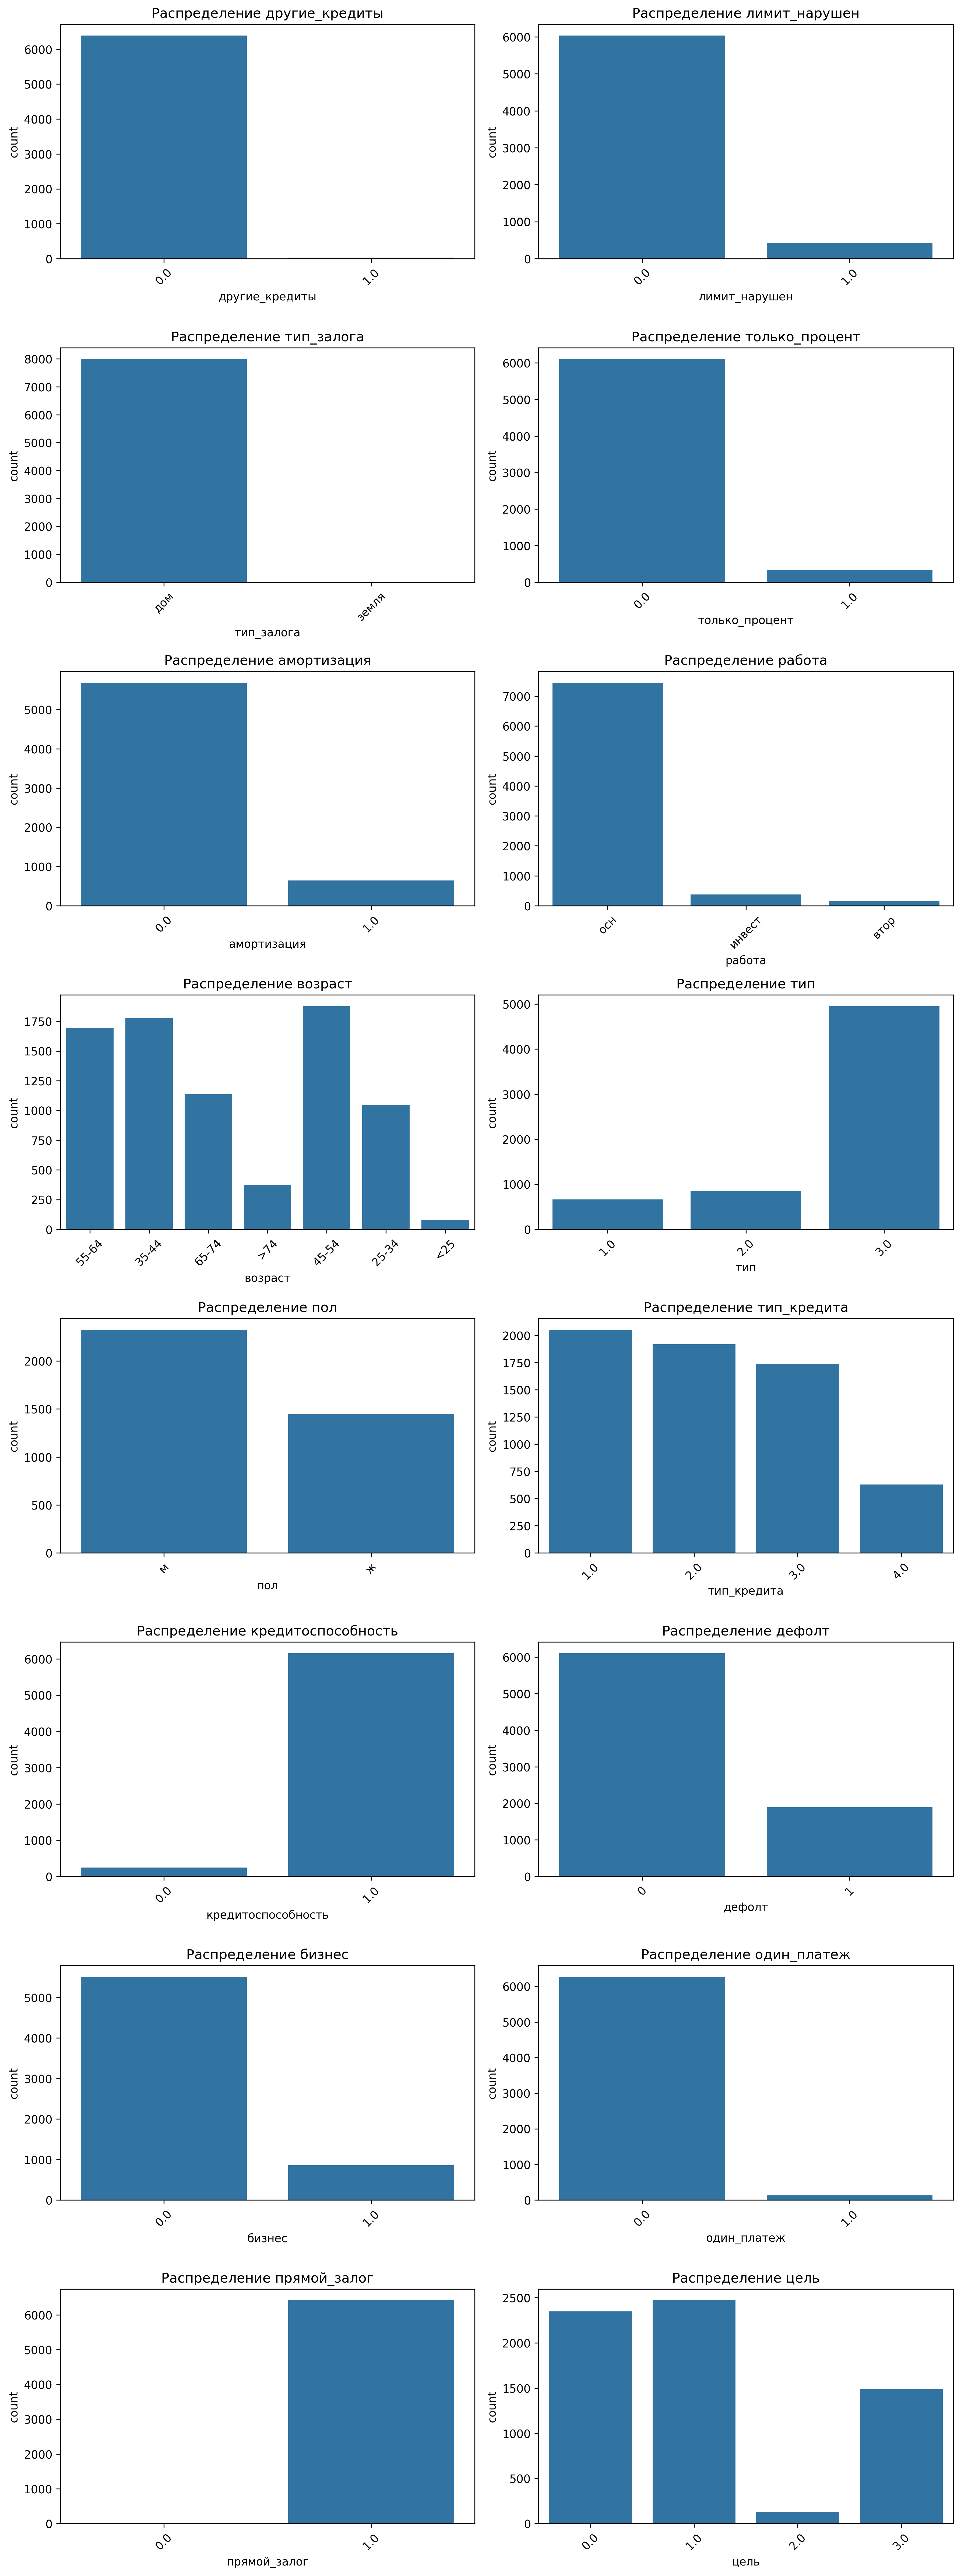

In [14]:
def plot_categorical_distributions(loan_data: pd.DataFrame) -> None:
    cat_feats = get_cat_cols(loan_data, for_plot=True)

    num_cols = 2
    num_rows = (len(cat_feats) + num_cols - 1) // num_cols

    plt.figure(figsize=(12, num_rows * 4))

    for i, col in enumerate(cat_feats):
        plt.subplot(num_rows, num_cols, i + 1)
        sns.countplot(data=loan_data, x=col)
        plt.title(f"Распределение {col}")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


plot_categorical_distributions(loan_data)

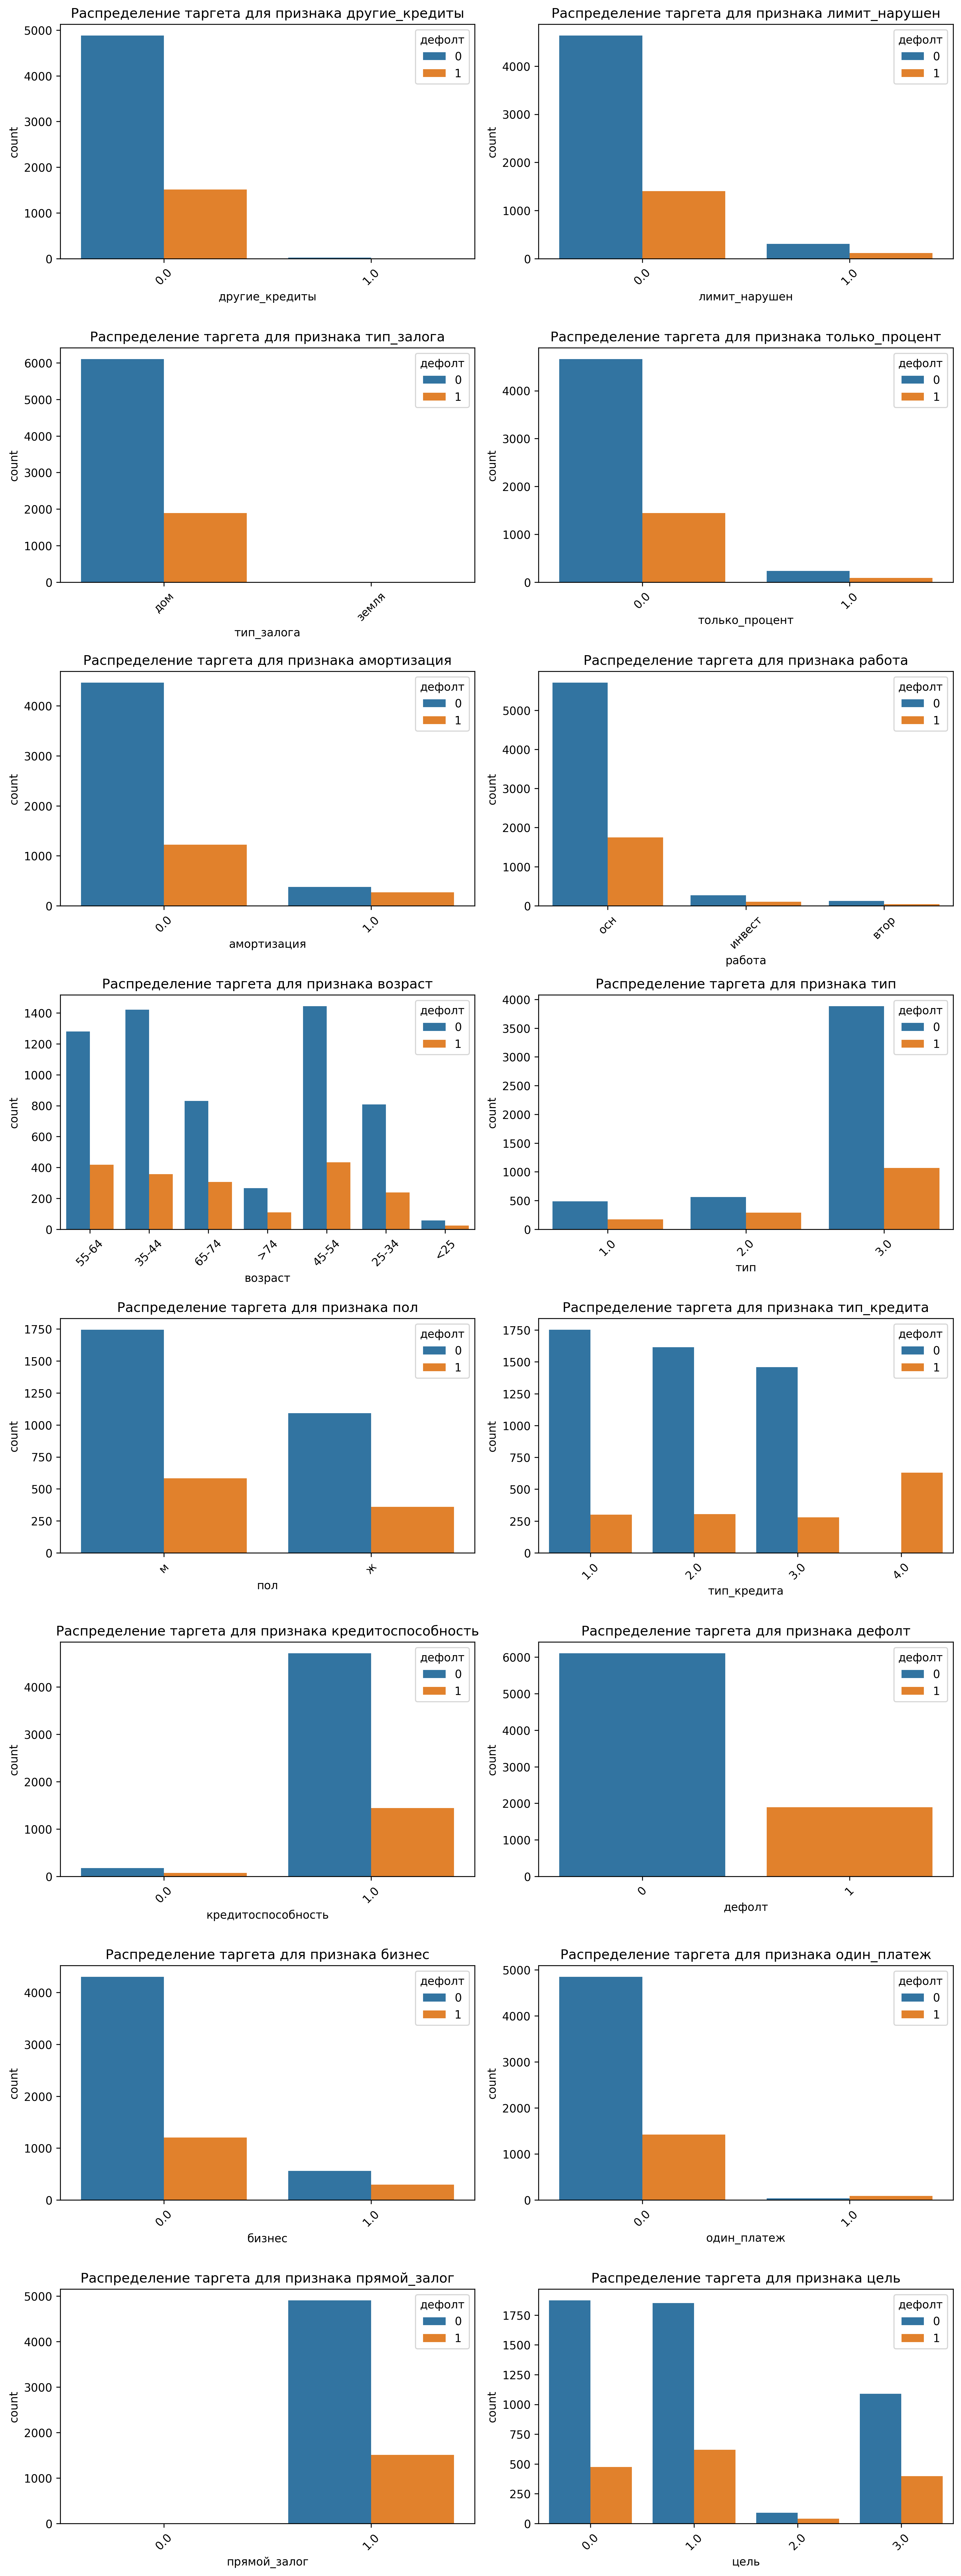

In [15]:
def visualize_cat_and_target(loan_data: pd.DataFrame) -> None:
    cat_feats = get_cat_cols(loan_data, for_plot=True)
    num_cols = 2
    num_rows = (len(cat_feats) + num_cols - 1) // num_cols

    plt.figure(figsize=(12, num_rows * 4))
    for i, col in enumerate(cat_feats):
        plt.subplot(num_rows, num_cols, i + 1)
        # fig, ax = plt.subplots(figsize=(3, 2))
        sns.countplot(x=col, hue=TARGET, data=loan_data)
        plt.title(f"Распределение таргета для признака {col}")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


visualize_cat_and_target(loan_data)

### Датасет: пропущенные значения

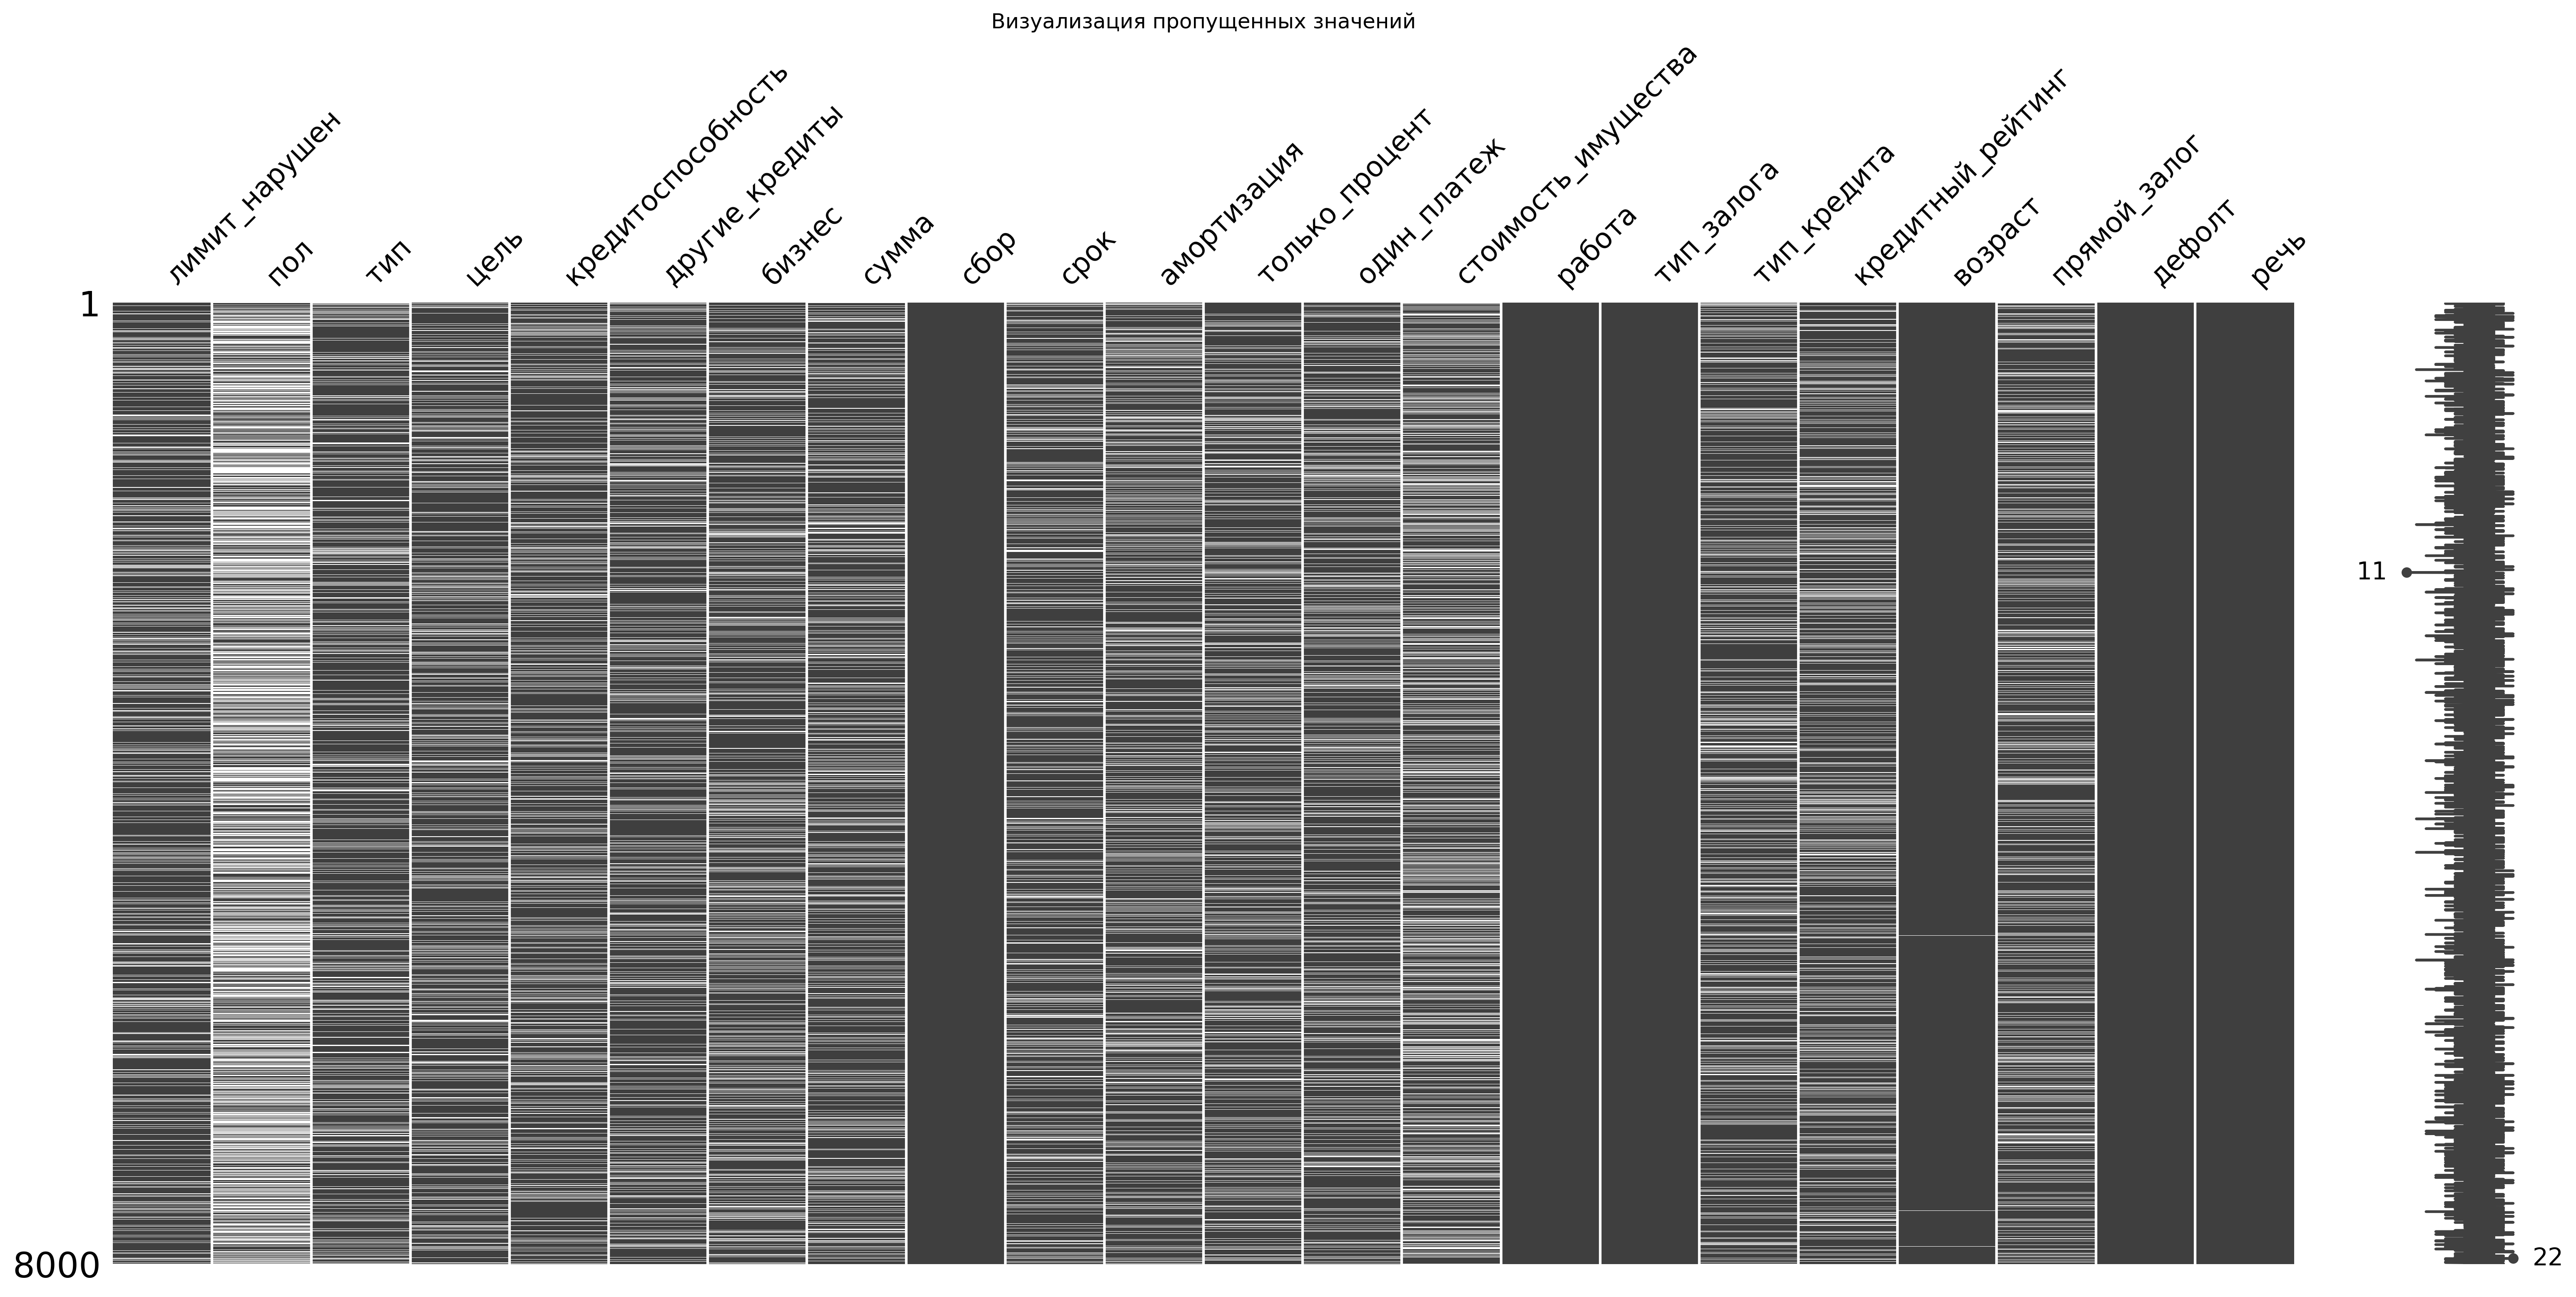

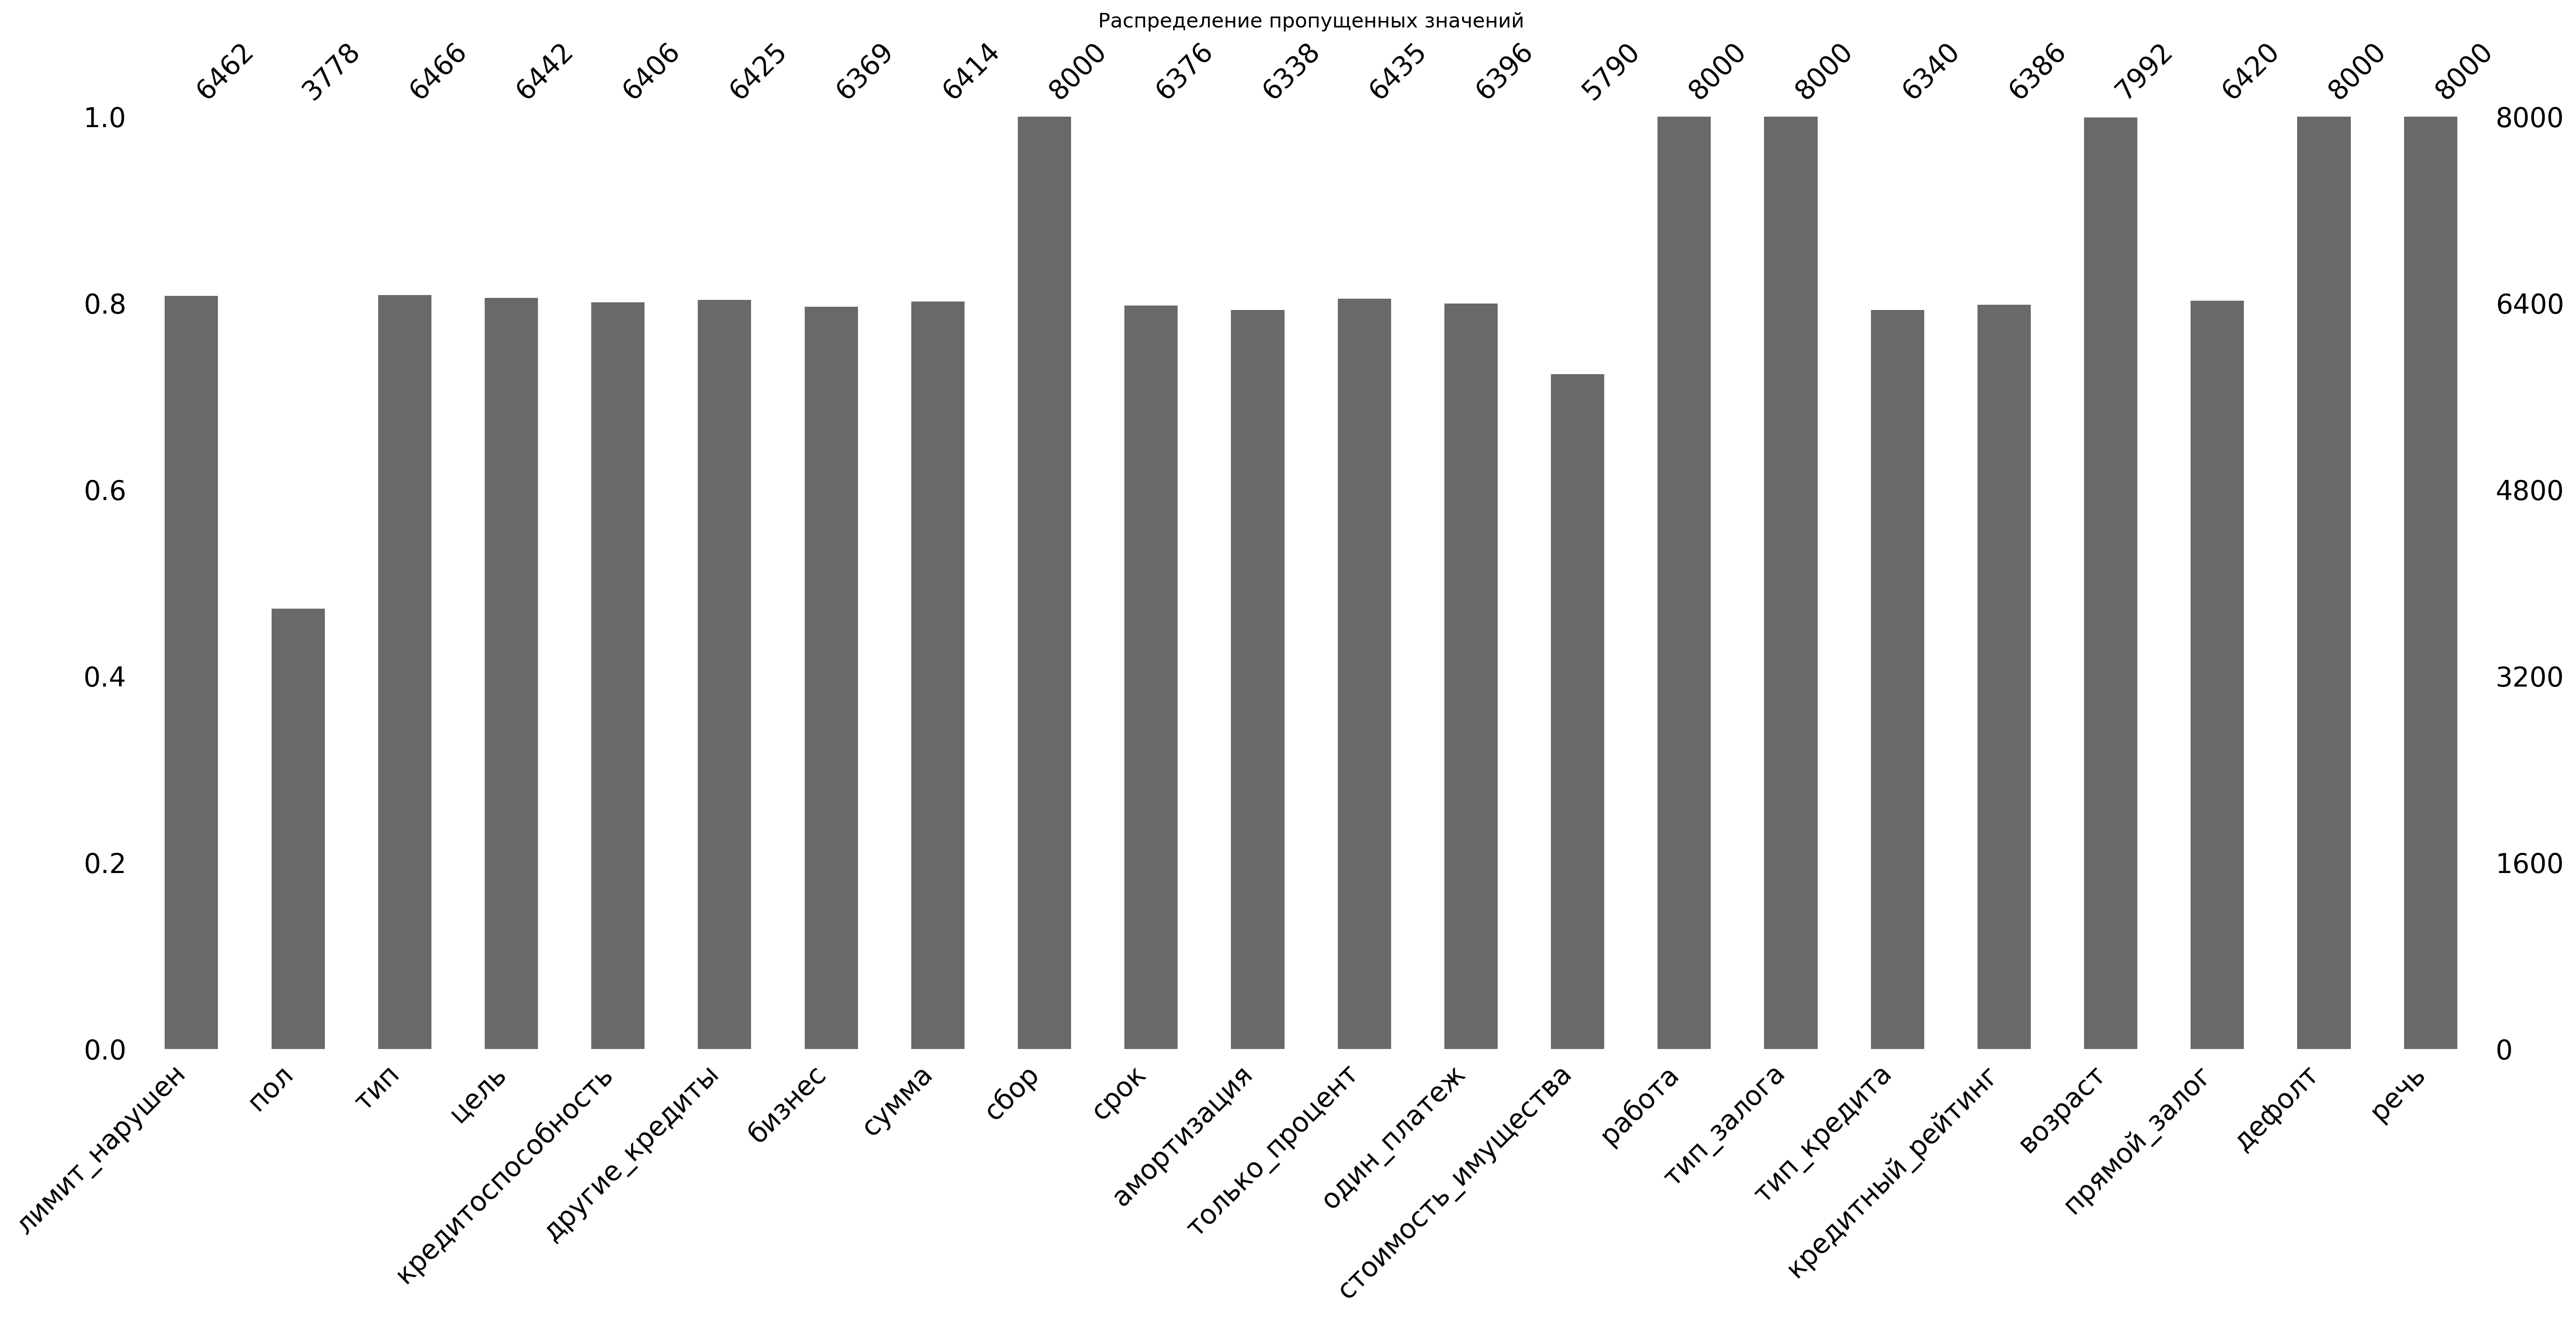

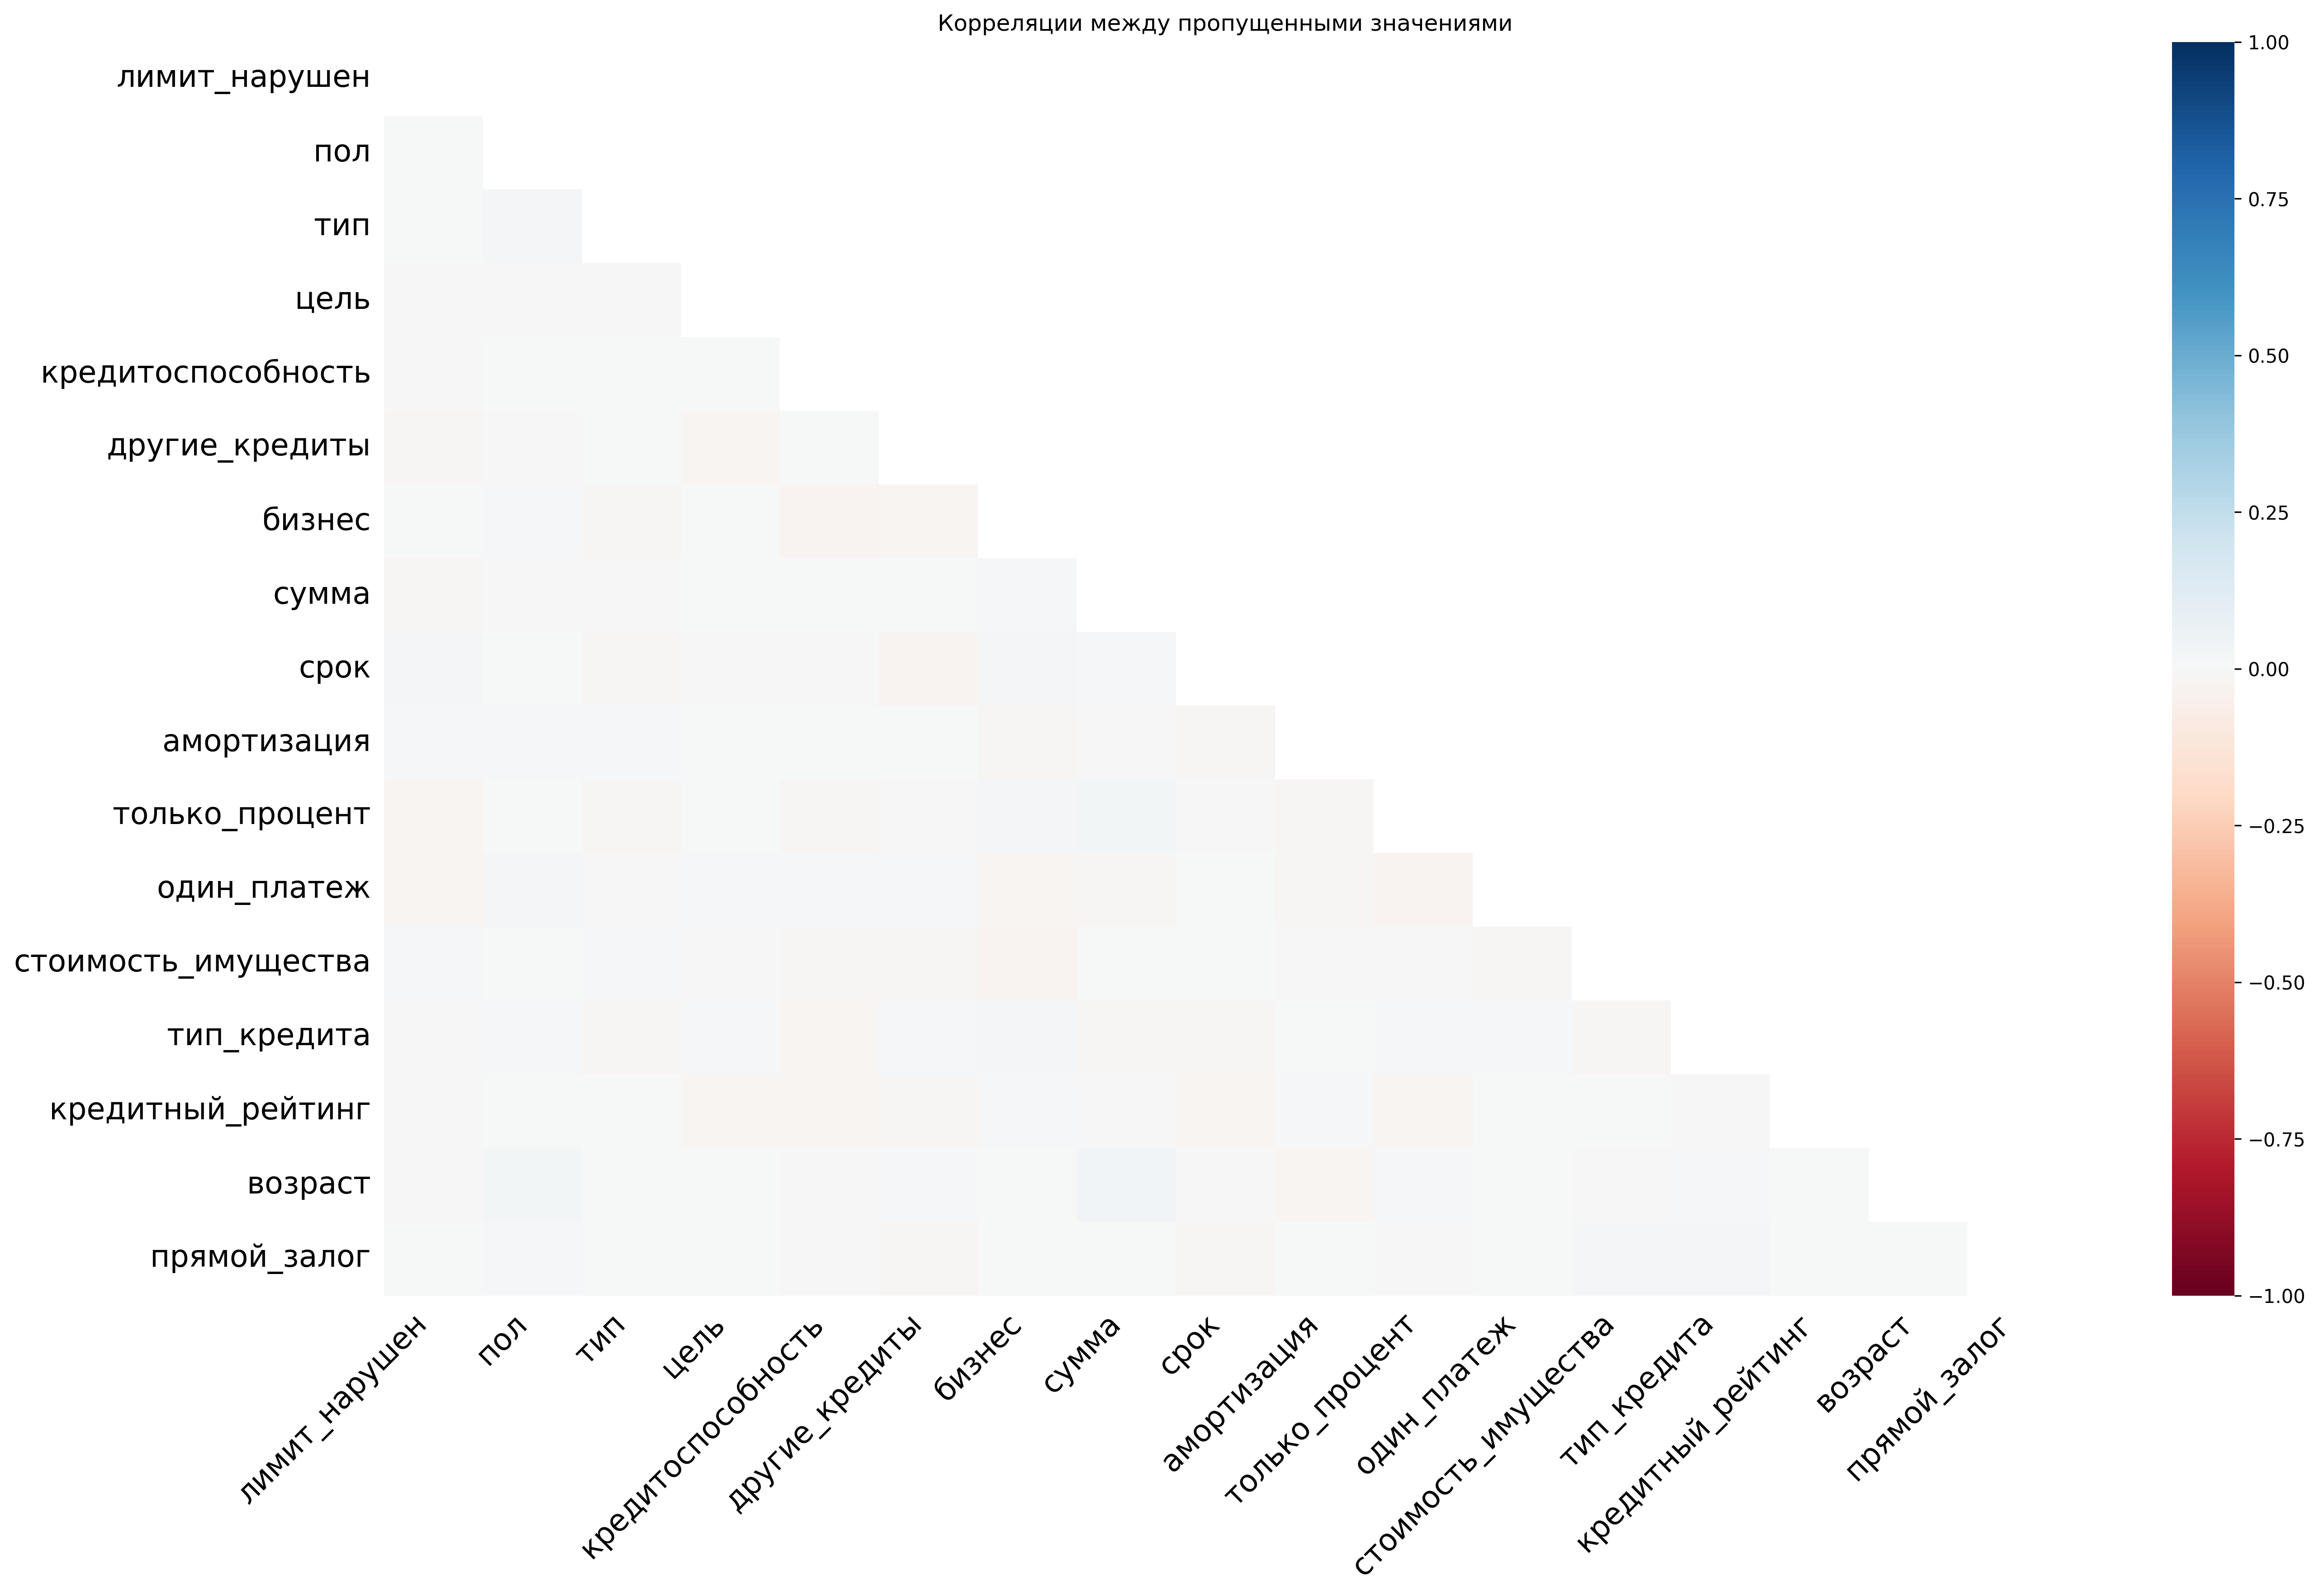

In [16]:
import missingno as msno

msno.matrix(loan_data)
plt.title("Визуализация пропущенных значений")
plt.show()
msno.bar(loan_data)
plt.title("Распределение пропущенных значений")
plt.show()
msno.heatmap(loan_data)
plt.title("Корреляции между пропущенными значениями")
plt.show()


### Датасет: анализ аномалий

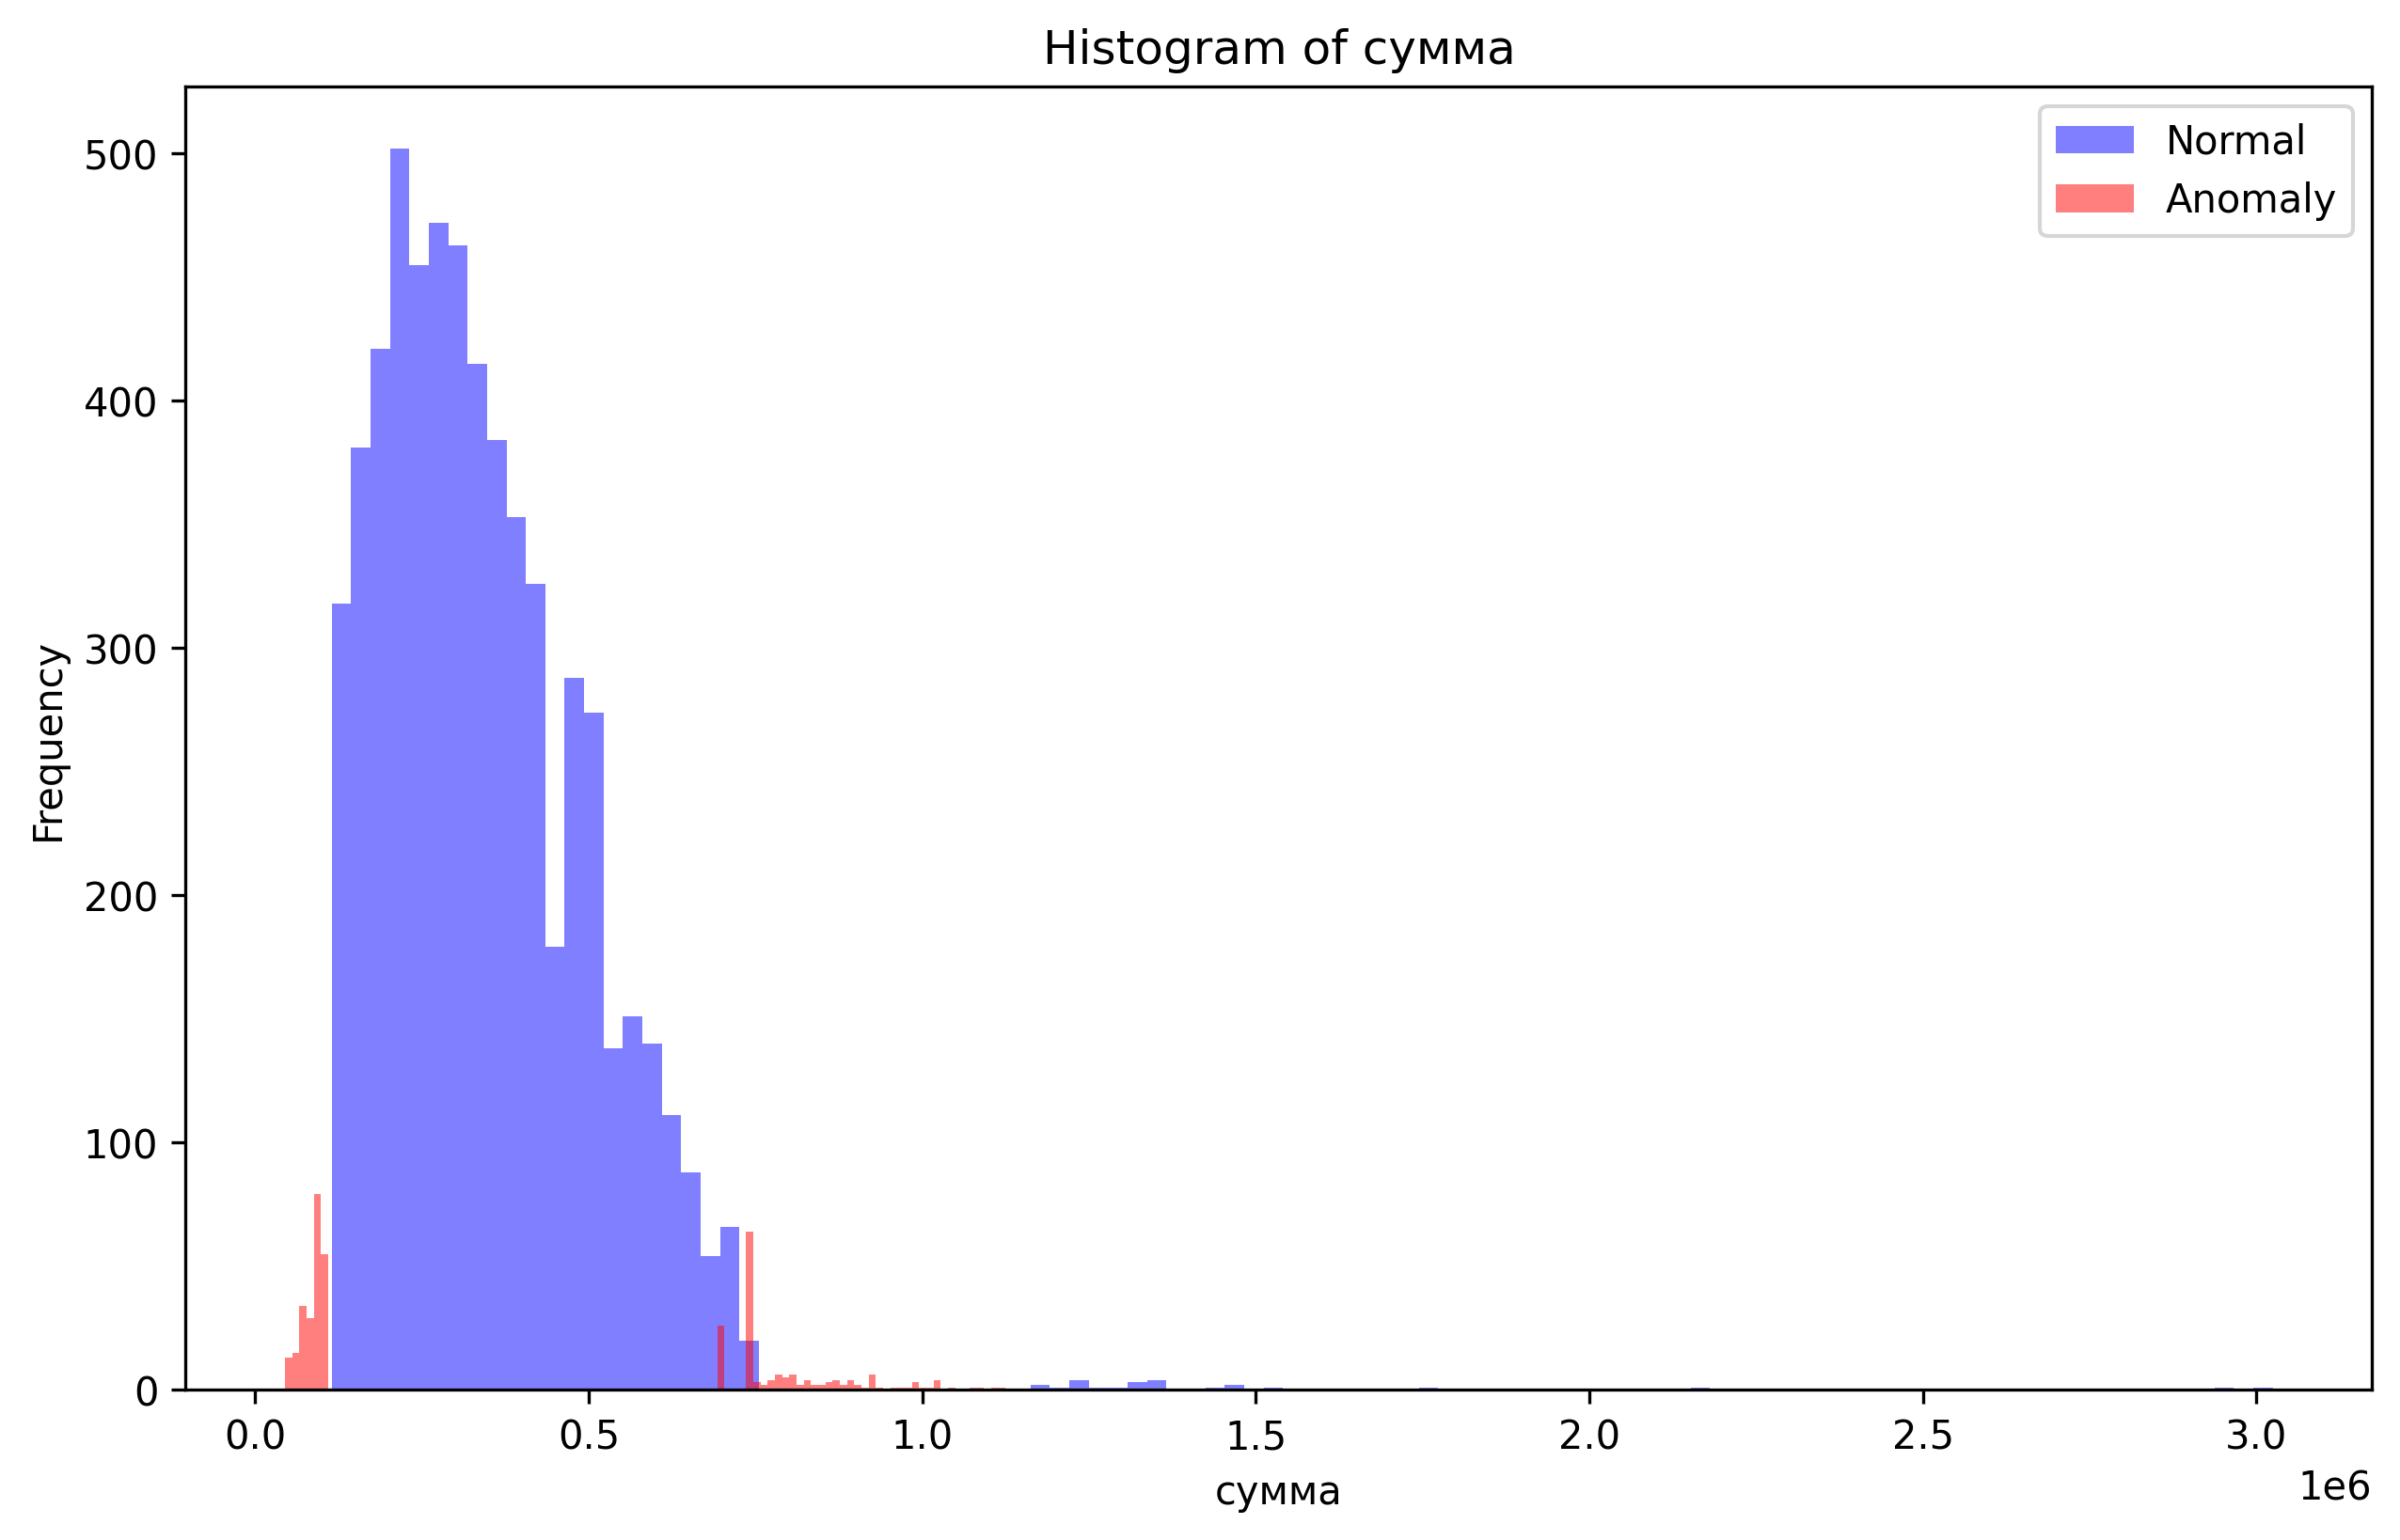

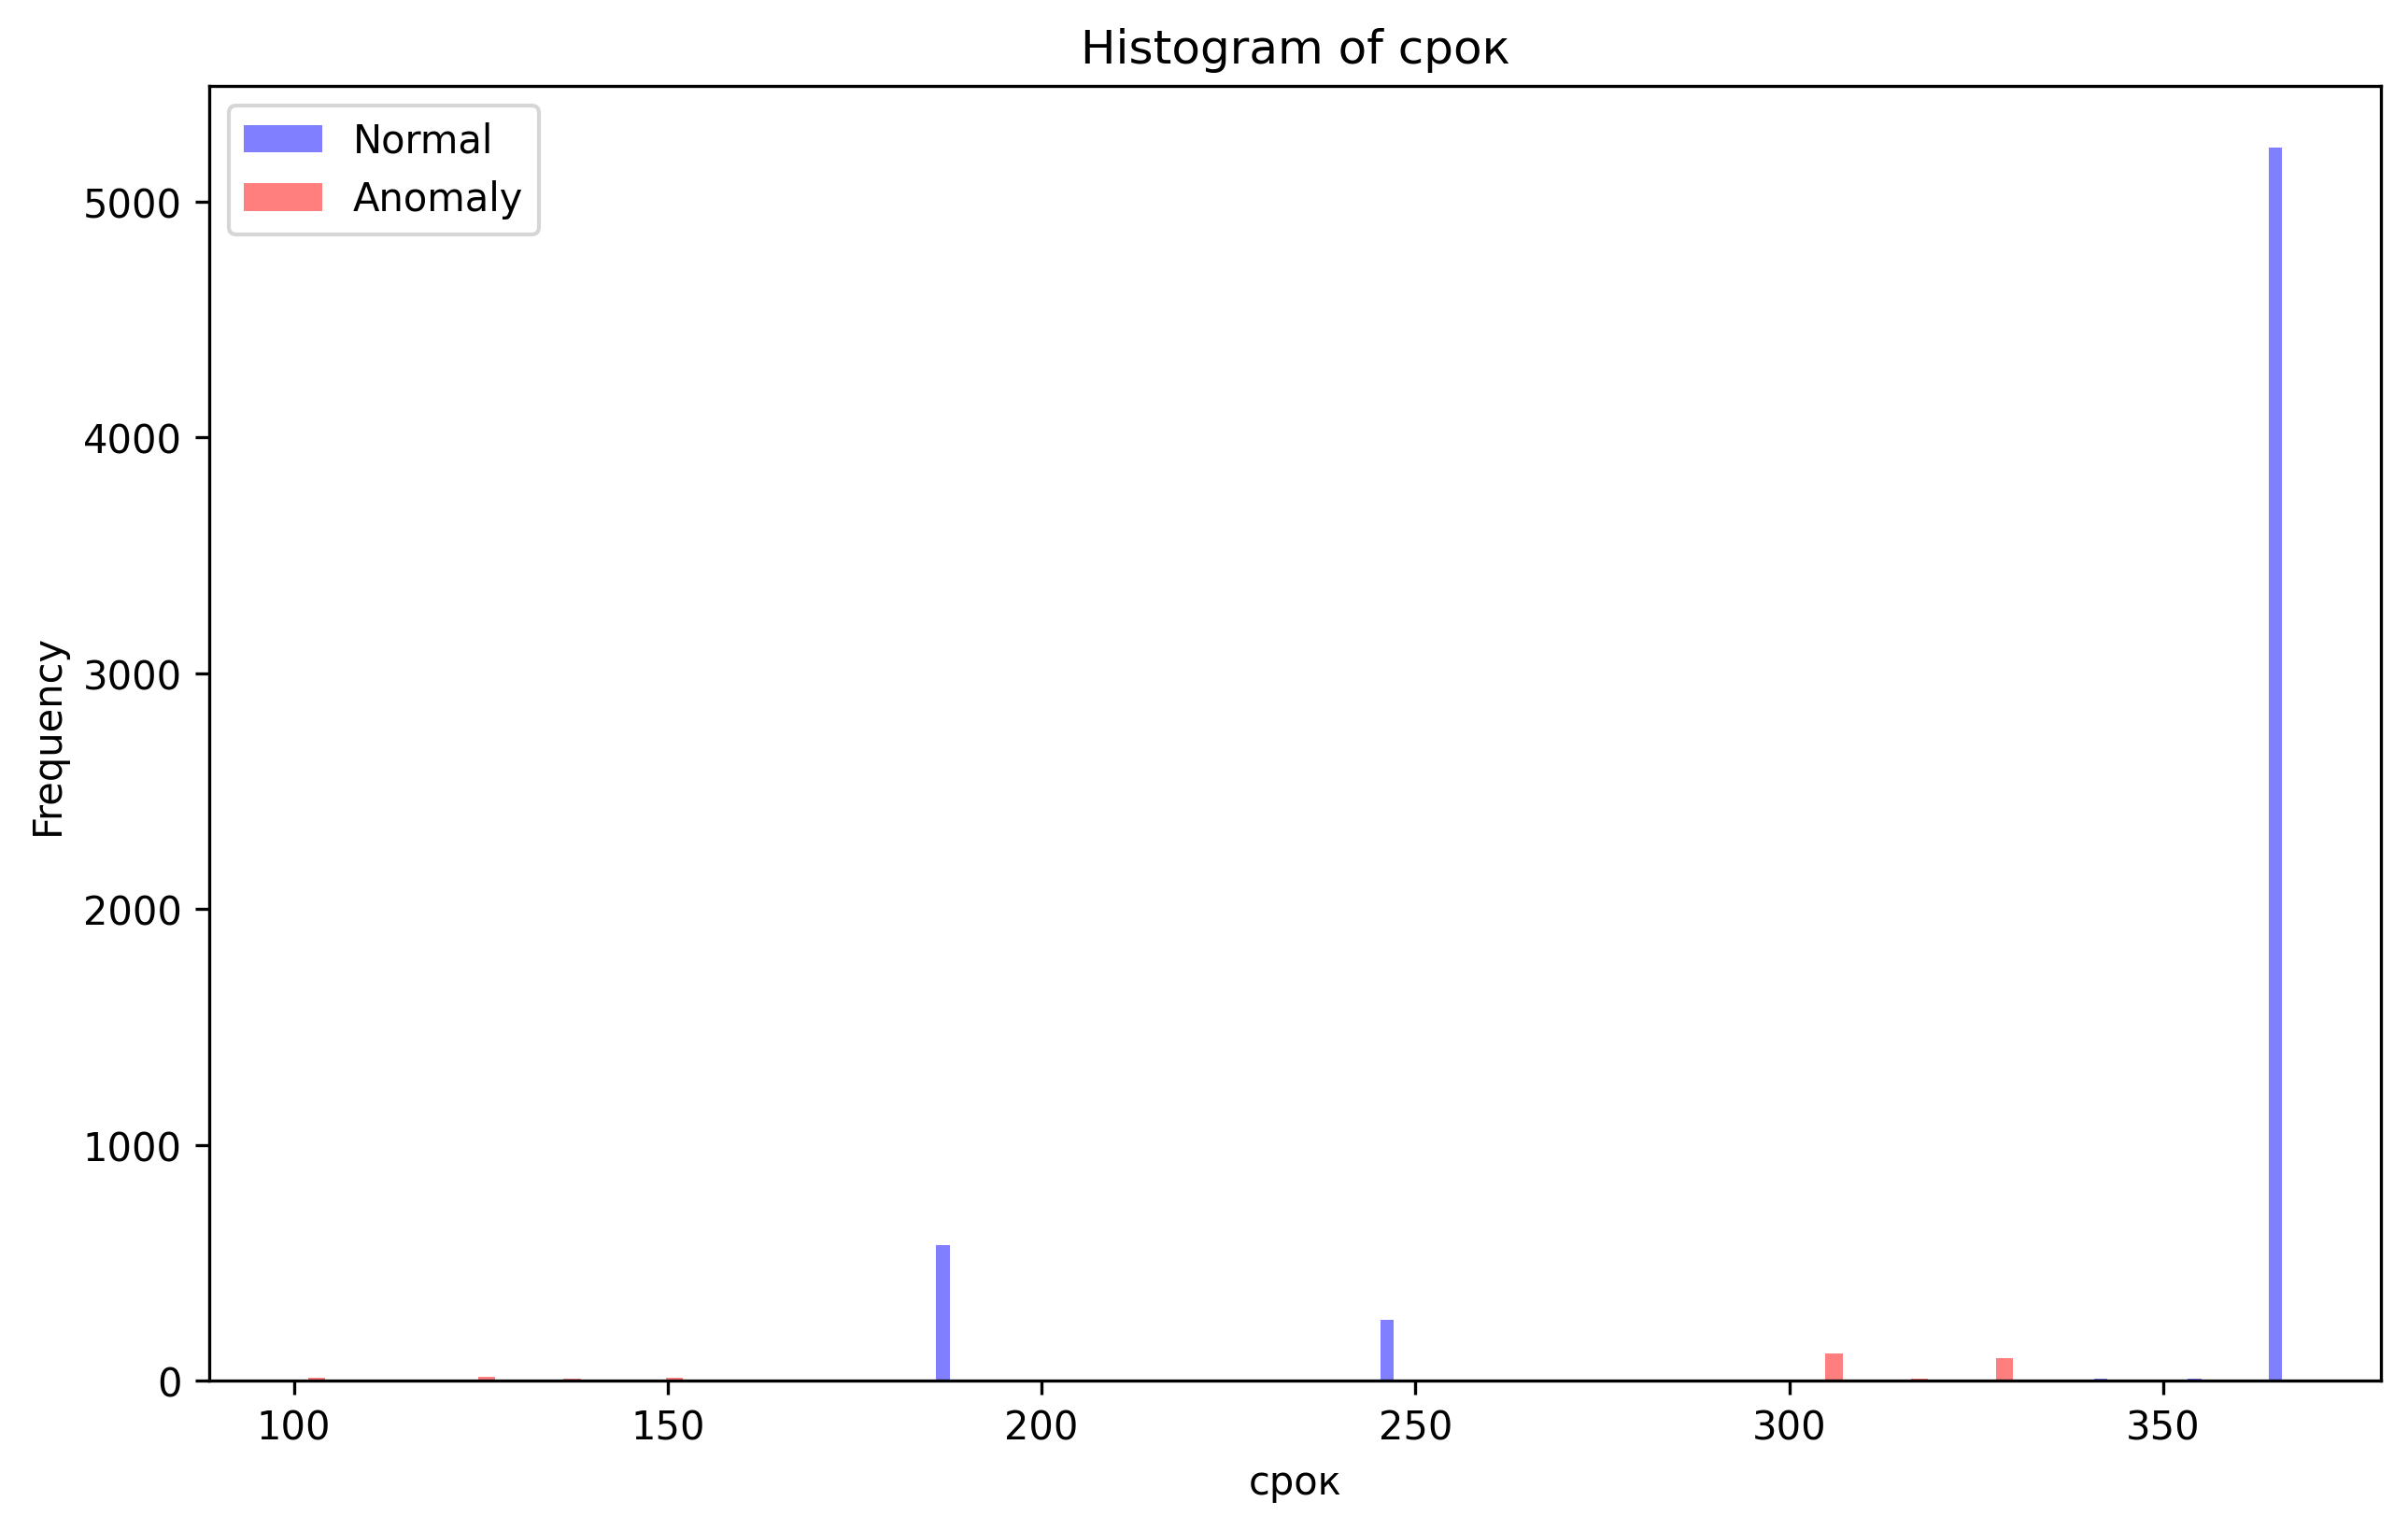

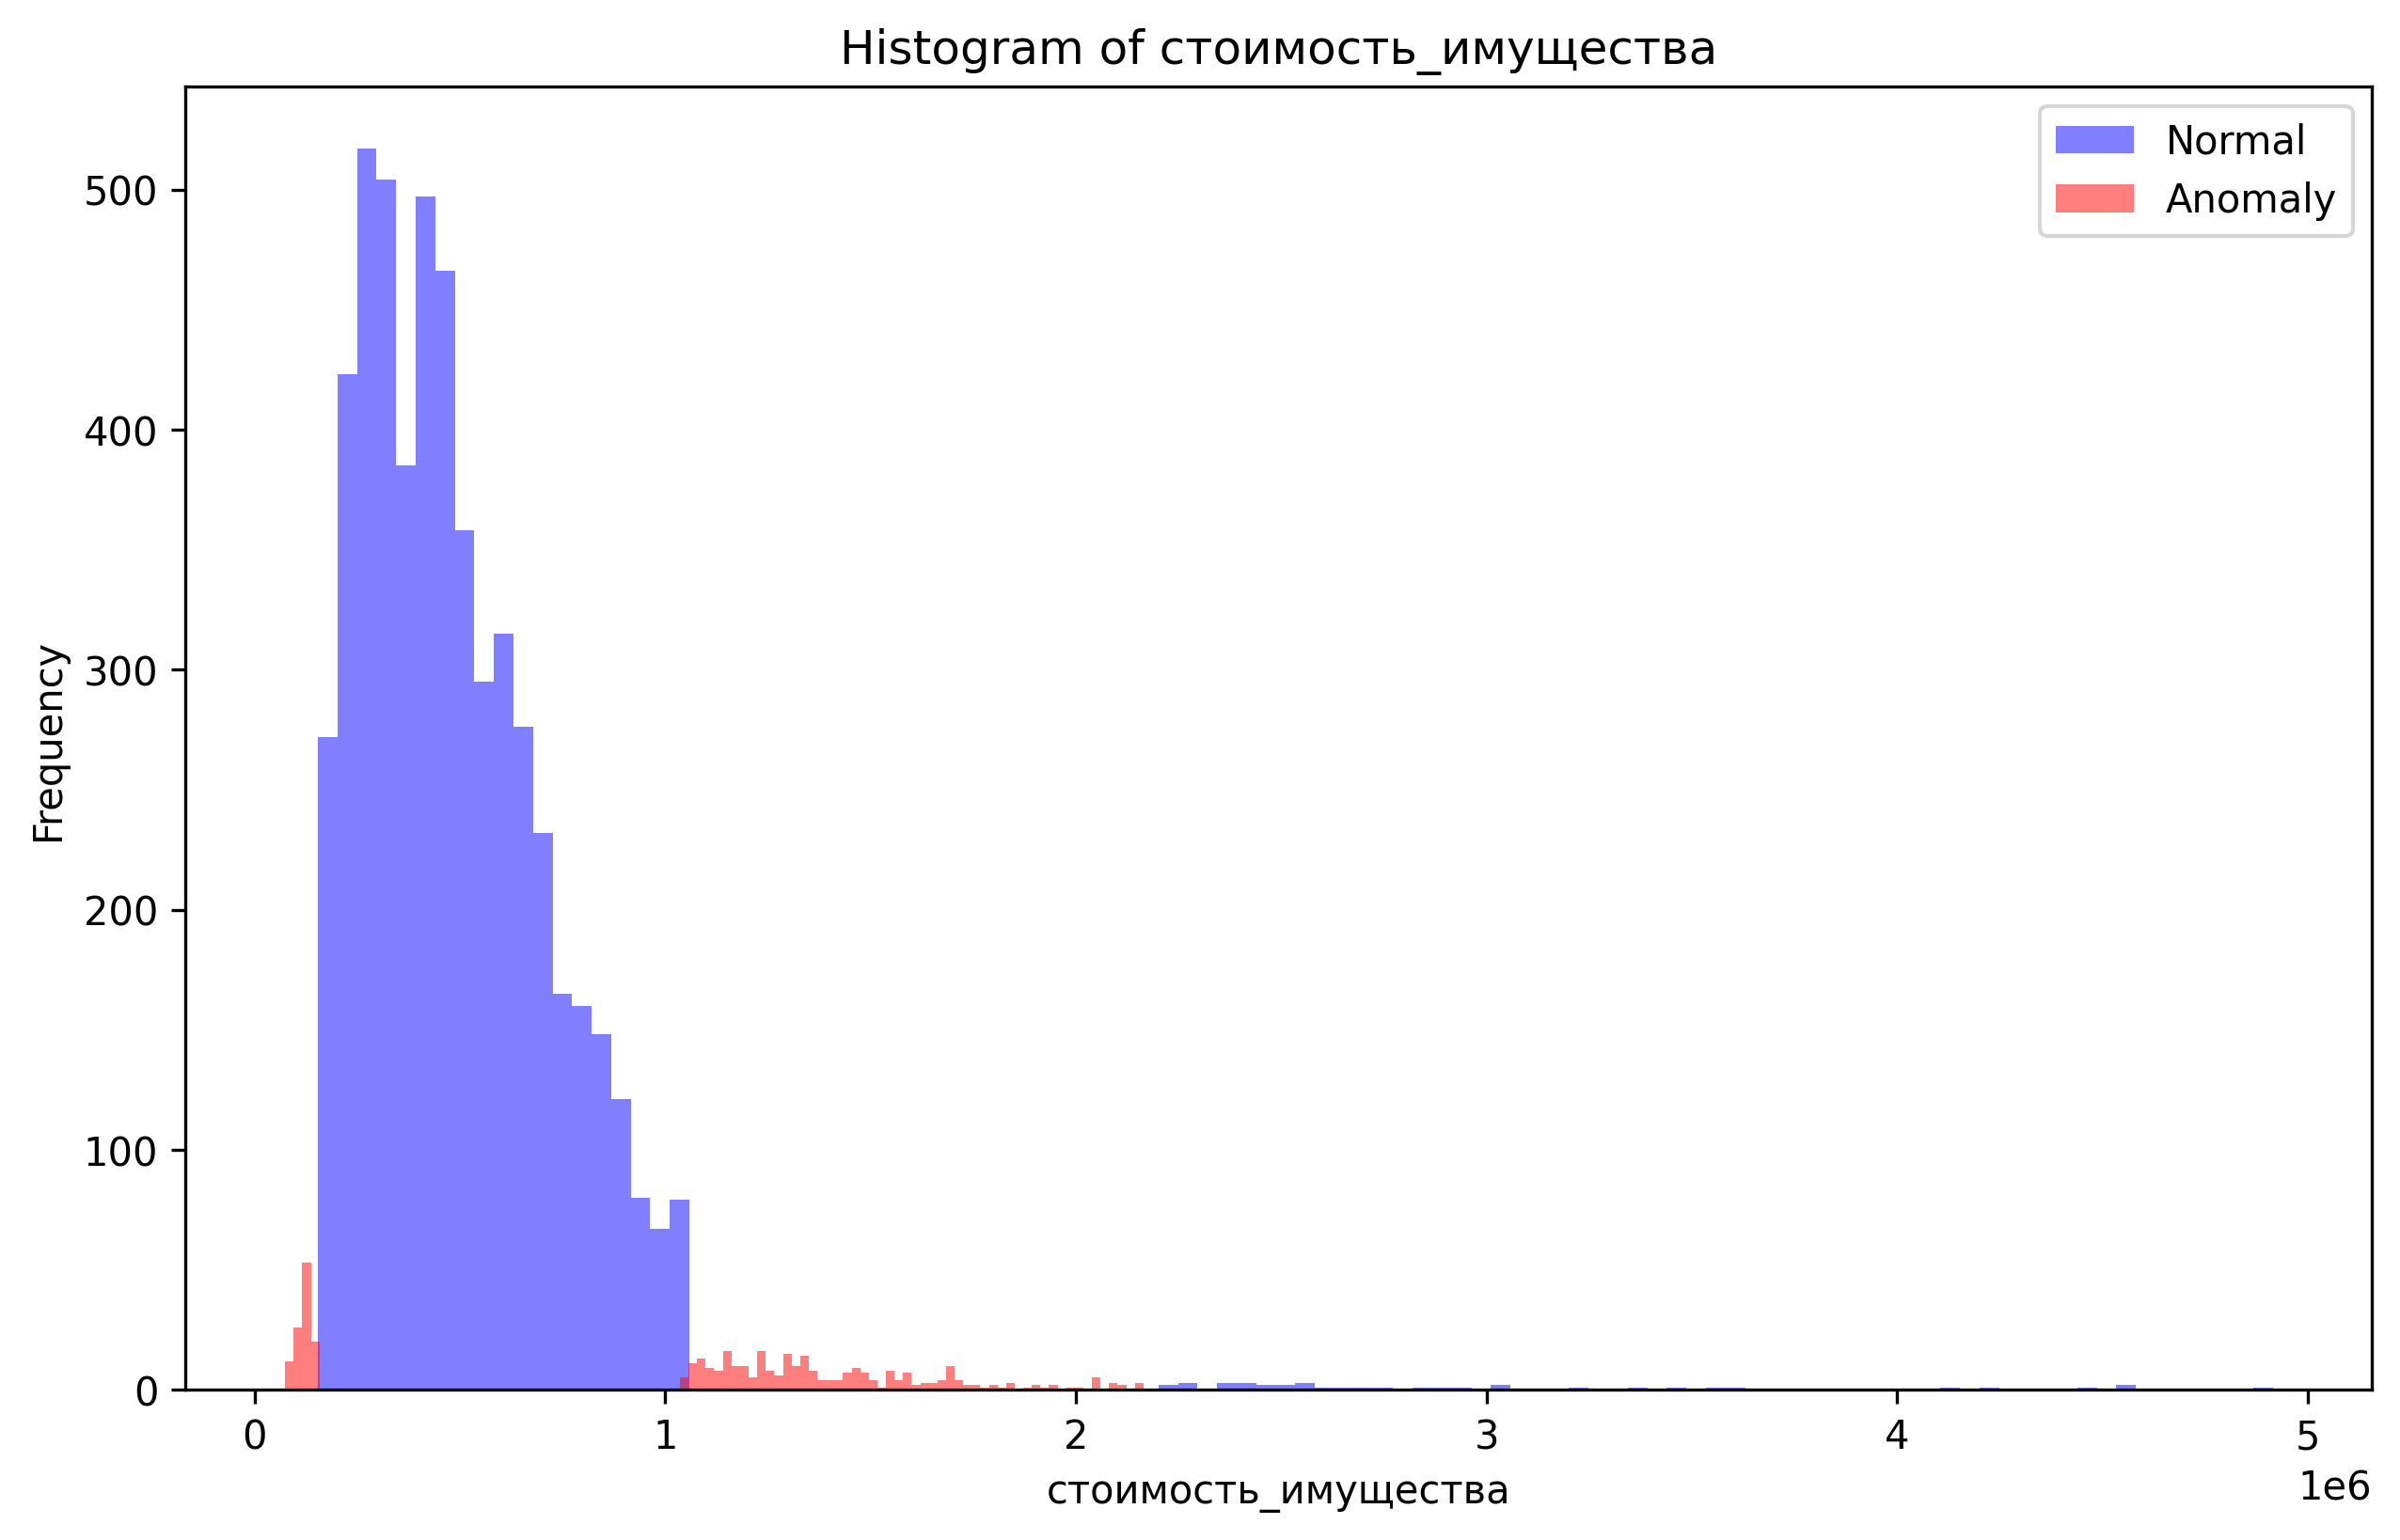

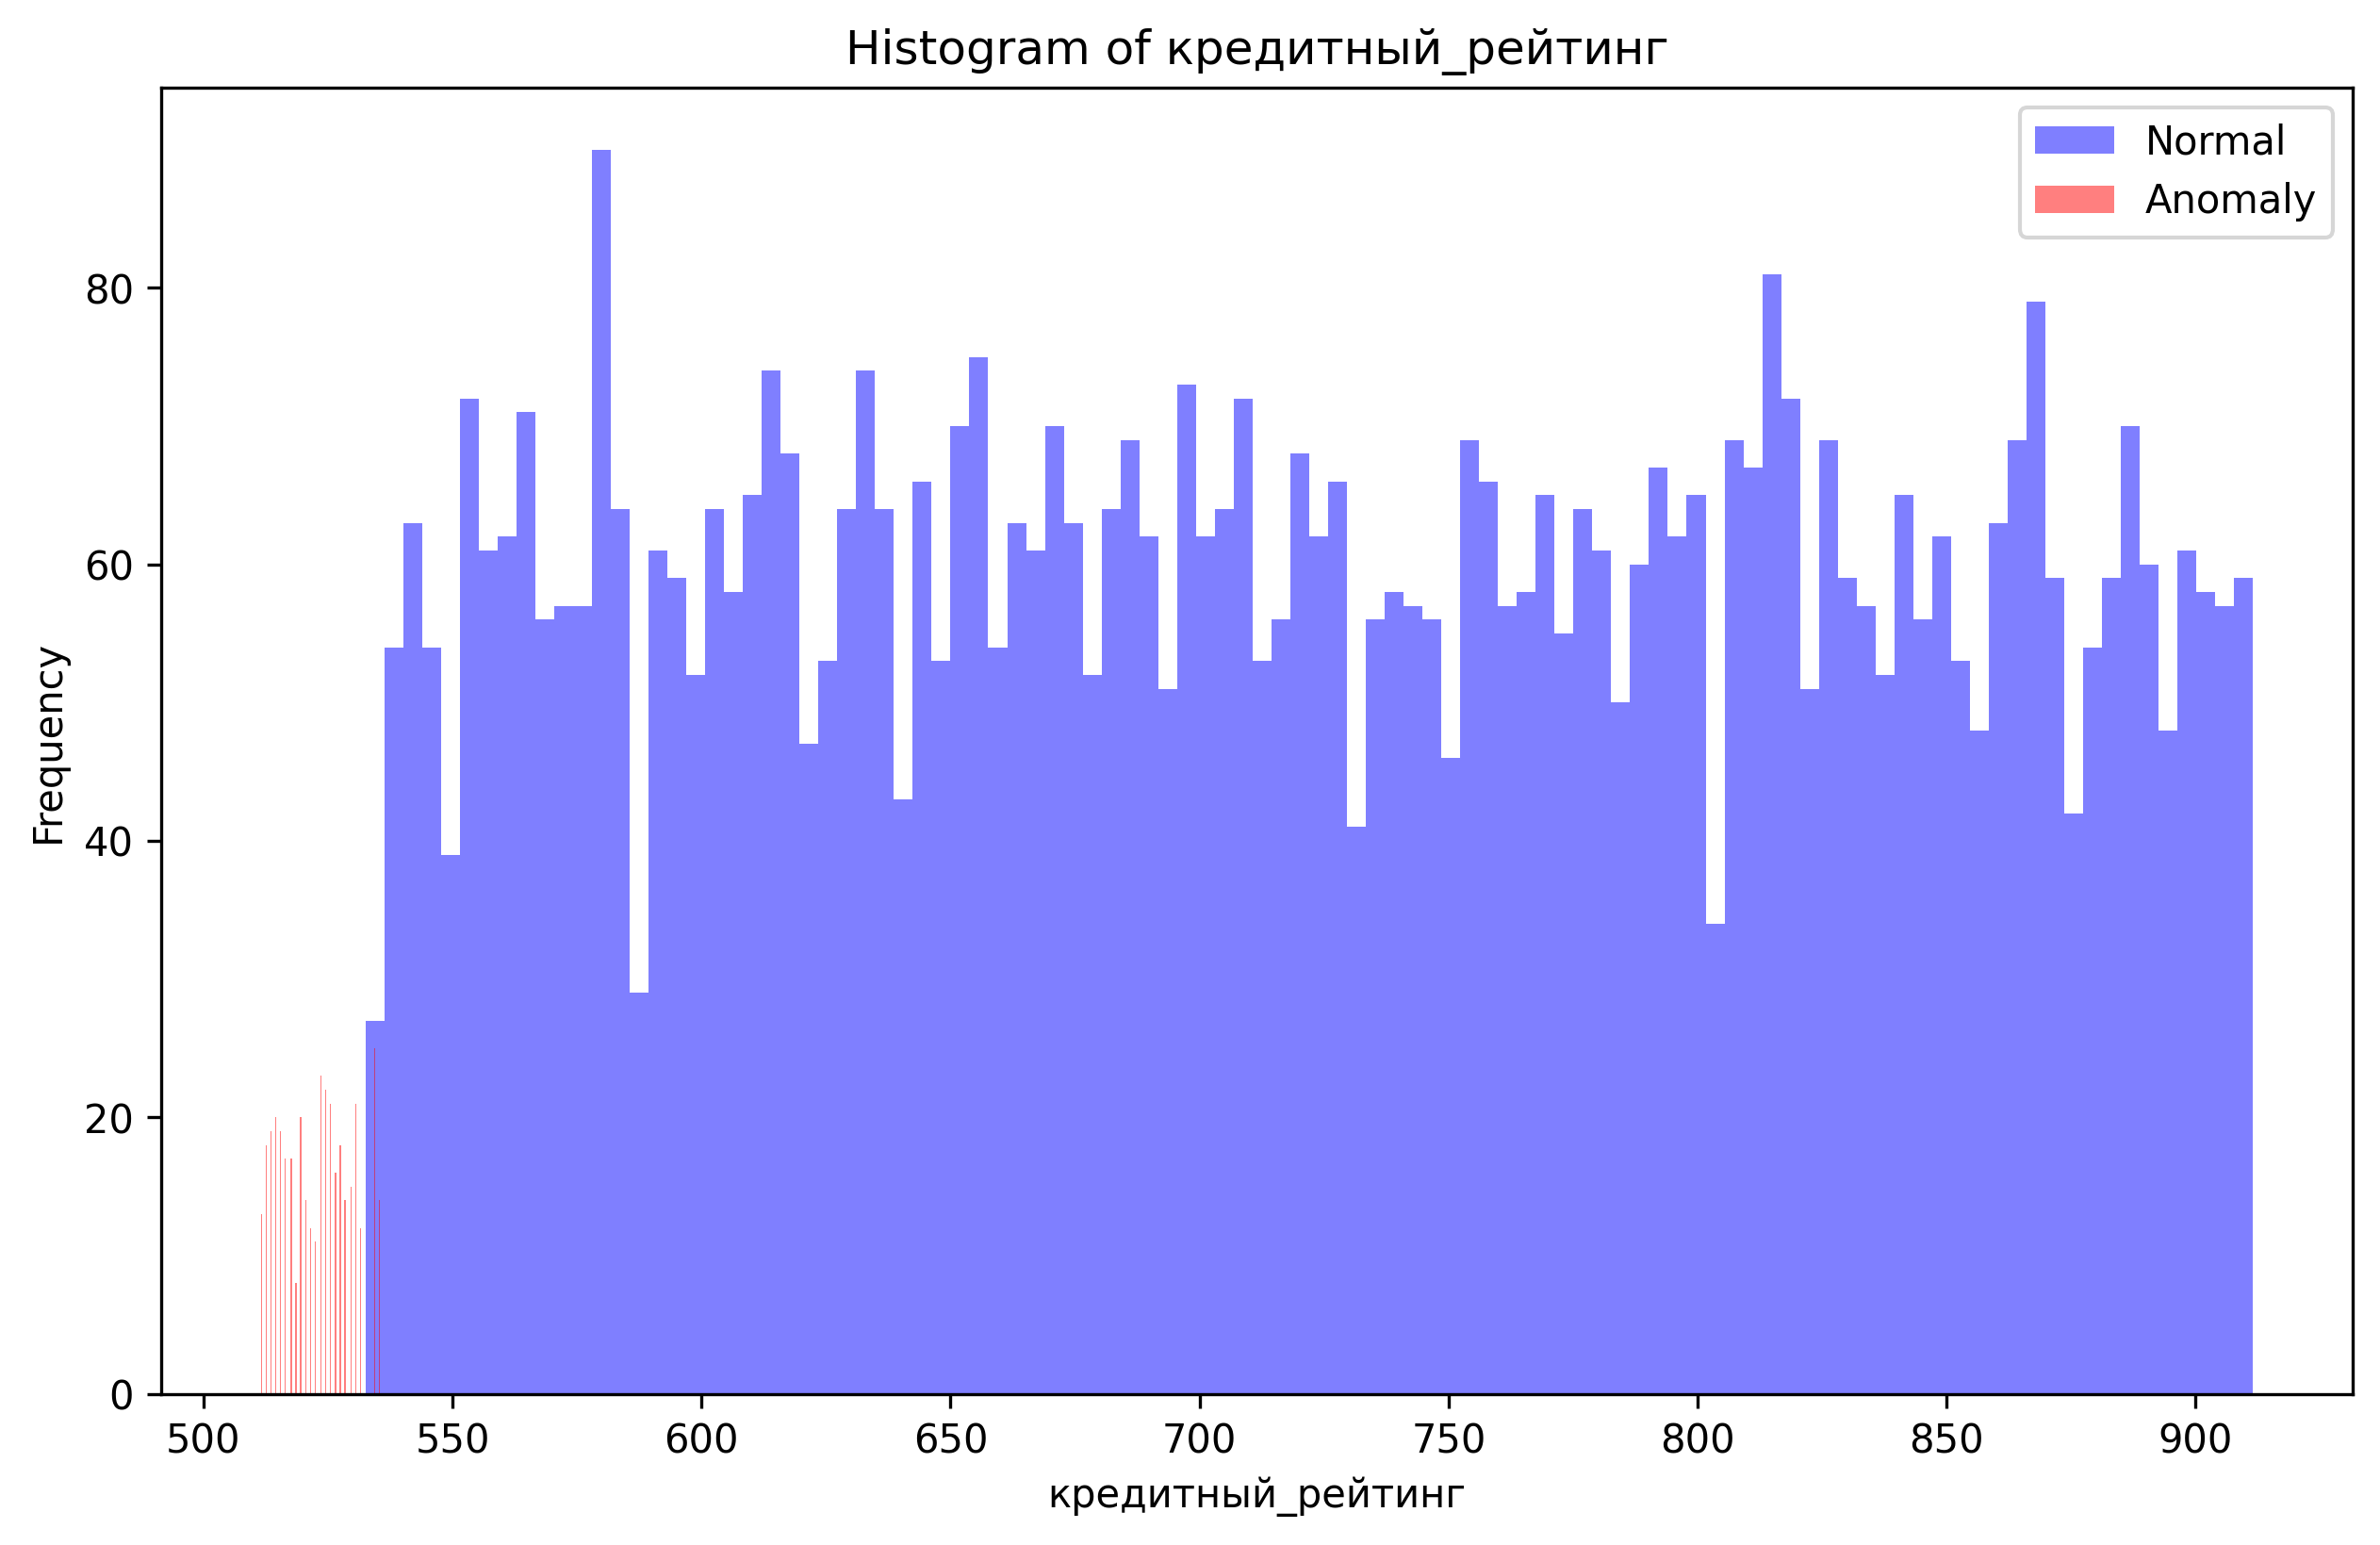

In [17]:
from typing import cast
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest


def get_anomaly_mask(loan_data: pd.DataFrame, col: str) -> np.ndarray:
    model = IsolationForest(contamination=0.05)
    return cast(np.ndarray, model.fit_predict(loan_data[[col]]) == -1)


def plot_anomalies(loan_data: pd.DataFrame, bins: int = 100) -> None:
    num_cols = get_num_cols(loan_data)
    for col in num_cols:
        anomaly_mask = get_anomaly_mask(loan_data, col)

        plt.figure(figsize=(10, 6))
        plt.hist(loan_data[col][~anomaly_mask], bins=bins, alpha=0.5, label="Normal", color="blue")
        plt.hist(loan_data[col][anomaly_mask], bins=bins, alpha=0.5, label="Anomaly", color="red")
        plt.title(f"Histogram of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()


plot_anomalies(loan_data)


### Модель: выделить трейн/тест

In [18]:
def get_train_test(loan_data: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_train, df_test = train_test_split(loan_data, test_size=0.33, random_state=42)
    return df_train, df_test


get_train_test(loan_data)[0].shape, get_train_test(loan_data)[1].shape

((5360, 22), (2640, 22))

In [19]:
def print_metrics(y_true: np.ndarray | pd.DataFrame, y_pred: np.ndarray | pd.DataFrame) -> None:
    acc = (y_pred == y_true).mean()
    print("Log reg")
    print(f"Accuracy: {acc:.3f}")
    f1 = f1_score(y_pred=y_pred, y_true=y_true)
    print(f"f1: {f1:.3f}")


def train_log_reg(loan_data: pd.DataFrame) -> None:
    df_train, df_test = get_train_test(loan_data)

    X_train, y_train = get_xy(df_train)
    X_test, y_test = get_xy(df_test)

    num_cols = X_train.select_dtypes(exclude=object).columns

    pipe = Pipeline(
        [
            ("feat_select", ManualFeatureSelector(num_cols)),
            ("impute", SimpleImputer(strategy="constant", fill_value=0)),
            ("model", LogisticRegression(random_state=42)),
        ]
    )

    pipe.fit(X_train, y_train)

    print("Train")
    pred = pipe.predict(X_train)
    print_metrics(y_pred=pred, y_true=y_train)
    print()

    print("Test")
    pred = pipe.predict(X_test)
    print_metrics(y_pred=pred, y_true=y_test)
    print()


train_log_reg(loan_data)

Train
Log reg
Accuracy: 0.815
f1: 0.426

Test
Log reg
Accuracy: 0.797
f1: 0.410



/Users/user/Main/Repos/hse-ml-managers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Так как я организовал модели в пайплайнах, я могу довольно просто добавлять туда еще элементы предобработки вроде нормализации и обработки пропущенных значений

### Бизнес: какую метрику использовать

Тут я так понимаю студенты сами будут придумывать подходящую метрику